In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [14]:
raw_db = pd.read_csv('D:\Big_Data\Job\Digital_twin\Data\ForFBpost.csv')
raw_db.info()
raw_db.head()
db = raw_db.join(raw_db['Город;year;fact;Модель;Нижняя граница;Верхняя граница'].str.split(';', n=6, expand=True).rename(columns={
    0:'Город', 1:'year', 2:'fact', 3:'Модель', 4: 'Нижняя граница', 5:'Верхняя граница'}))
db = db.drop('Город;year;fact;Модель;Нижняя граница;Верхняя граница', axis=1)
# db.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30250 entries, 0 to 30249
Data columns (total 1 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   Город;year;fact;Модель;Нижняя граница;Верхняя граница  30250 non-null  object
dtypes: object(1)
memory usage: 236.5+ KB


In [15]:
unique_cities = db['Город'].nunique()
print("Всего городов:", unique_cities)
cities_df = db['Город'].drop_duplicates()
cities_df = cities_df.reset_index()
cities_df.columns = ['Index', 'Город']
# cities_df.head()
# pd.set_option('display.max_rows', None)# Сброс ограничений на количество выводимых рядов
# pd.set_option('display.max_columns', None)# Сброс ограничений на число столбцов
# pd.set_option('display.max_colwidth', None)# Сброс ограничений на количество символов в записи
# print(cities_df)


Всего городов: 248


В данной базе данных всего 248 городов. Однако, делать социально-экономические выводы и гипотезы для каждого города, с моей точки, не практично. Мне кажется, для начала следует рассмотреть общую динамику развития населения, а затем анализировать что-то конкретное. Поэтому, я разделил базу данных на регионы и округа. Таким образом, будет заметна целочисленная динамика развития населения.

In [16]:
'''Поиск конкретного города.''' #С помощью этого мини-блока можно проверить наличие интересующего города в датасете. Я проверял наличие Москвы и Санкт-Петербурга
result_MSK = cities_df.loc[cities_df['Город'] == 'Москва'] 
result_SPB = cities_df.loc[cities_df['Город'] == 'Санкт-Петербург']

if not result_MSK.empty:
    print('Город Москва есть')
else:
    print('Города Москва нет')

if not result_SPB.empty:
    print('Город Санкт-Петербург есть')
else:
    print('Города Санкт-Петербург нет')


Город Москва есть
Города Санкт-Петербург нет


Перед запуском дальнейших модулей прочитать!!! Я прикрепил к письму файл с базами данных. Если нет необходимости проверять работу геокодера, то можно перейти на модуль, который использует файл (он идет сразу после геокодера, закомментирован). Если геокодер после нескольких раз не сработал, то, вероятнее всего привышен лимит запросов на геокодер, и придется использовать файл.

In [17]:
''' Добавление геокодера для распределение городов по регионам.'''

import requests

API_KEY = '1a43fc89-7216-4707-8421-da2dea4b05b7'  #API-ключ от Яндекс Геокодера

def get_region_with_yandex(city_name):
    url = f'https://geocode-maps.yandex.ru/1.x/?apikey={API_KEY}&format=json&geocode={city_name}&lang=ru_RU&kind=locality'
    response = requests.get(url)
    data = response.json()
    try:
        country_code = data['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['metaDataProperty']['GeocoderMetaData']['AddressDetails']['Country']['CountryNameCode']
        if country_code == 'RU':
            return data['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['metaDataProperty']['GeocoderMetaData']['AddressDetails']['Country']['AdministrativeArea']['AdministrativeAreaName']
        else:
            return 'не в России'
    except (KeyError, IndexError):
        return 'нет данных'

cities_df['region'] = cities_df['Город'].apply(lambda x: get_region_with_yandex(x))
cities_df = cities_df[cities_df['region'] != 'не в России']
cities_df.head()
#1a43fc89-7216-4707-8421-da2dea4b05b7 - Второй API
#fae8c6ce-b5f1-44fe-8287-ae63e28a5623 - Первый API

Index        Город              region
0      0   Белокуриха      Алтайский край
1    121  Новоалтайск      Алтайский край
2    242    Краснодар  Краснодарский край
3    363        Анапа  Краснодарский край
4    484     Бородино   Красноярский край

In [18]:
'''
Этот модуль импортирует готовую базу данных ,которая была получена с геокодера.
Это необходимо для того, что лишний раз не запускать геокодер, т.к. количество запросов в день ограниченно 1000 раз.
'''
# cities_df = pd.read_csv('D:\Big_Data\Job\Digital_twin\Data\cities_df_norm.csv')
# cities_df.head()

'\nЭтот модуль импортирует готовую базу данных ,которая была получена с геокодера.\nЭто необходимо для того, что лишний раз не запускать геокодер, т.к. количество запросов в день ограниченно 1000 раз.\n'

In [19]:
# print(cities_df)
unique_regions = cities_df['region'].nunique()
print("Всего регионов:", unique_regions)

Всего регионов: 71


In [20]:
''' Проверяем, нормально ли сработал геокодер. Если в данном датафрейме есть хотя бы один город, нужно запустить позапрошлый модуль повторно.'''
new_cities_df = cities_df[cities_df['region'] == 'нет данных']
new_cities_df['region'] = new_cities_df['Город'].apply(lambda x: get_region_with_yandex(x))
new_cities_df.head()

Empty DataFrame
Columns: [Index, Город, region]
Index: []

In [21]:
'''Создаем словарь, сопоставляющий федеральному округу список регионов'''

federal_district_to_regions = {
    'Центральный': ['Москва', 'Белгородская область', 'Брянская область', 'Владимирская область', 'Воронежская область', 'Ивановская область', 'Тверская область', 'Калужская область', 'Костромская область', 'Курская область', 'Липецкая область', 'Московская область', 'Орловская область', 'Рязанская область', 'Смоленская область', 'Тамбовская область', 'Тульская область', 'Ярославская область'],  # список всех регионов в Центральном округе
    'Северо-Западный': ['Санкт-Петербург', 'Архангельская область', 'Вологодская область', 'Калининградская область', 'Ленинградская область', 'Мурманская область', 'Новгородская область', 'Псковская область', 'Республика Карелия', 'Республика Коми', 'Ненецкий автономный округ'],  # список всех регионов в Северо-Западном округе
    'Приволжский': ['Пермский край', 'Нижегородская область', 'Кировская область', 'Самарская область', 'Оренбургская область', 'Пензенская область', 'Саратовская область', 'Ульяновская область', 'Республика Башкортостан', 'Республика Марий Эл', 'Республика Мордовия', 'Республика Татарстан', 'Удмуртская Республика', 'Чувашская Республика'],
    'Уральский': ['Курганская область', 'Свердловская область', 'Тюменская область', 'Челябинская область', 'Ханты-Мансийский автономный округ', 'Ямало-Ненецкий автономный округ'],
    'Северо-Кавказский': ['Ставропольский край', 'Республика Ингушетия', 'Республика Дагестан', 'Республика Кабардино-Балкарская', 'Республика Северная Осетия — Алания', 'Карачаево-Черкесская Республика', 'Чеченская Республика'],
    'Южный': ['Севастополь', 'Краснодарский край', 'Астраханская область', 'Волгоградская область', 'Запорожская область', 'Ростовская область', 'Херсонская область', 'Республика Адыгея', 'Республика ДНР', 'Республика Калмыкия', 'Республика Крым', 'Республика ЛНР'],
    'Сибирский': ['Алтайский край', 'Красноярский край', 'Иркутская область', 'Кемеровская область', 'Новосибирская область', 'Омская область', 'Томская область', 'Республика Алтай', 'Республика Тыва','Республика Хакасия'],
    'Дальневосточный': ['Чукотский автономный округ', 'Еврейская автономная область', 'Приморский край', 'Хабаровский край', 'Камчатский край', 'Забайкальский край', 'Республика Бурятия', 'Республика Саха (Якутия)', 'Амурская область', 'Магаданская область', 'Сахалинская область']
    # и т.д. для остальных федеральных округов
}

def map_region_to_federal_district(region):
    for key, value in federal_district_to_regions.items():
        if region in value:
            return key
    return 'Другой'  # Если регион не входит в перечень федеральных округов, возвращаем 'Другой'

cities_df['federal_district'] = cities_df['region'].apply(map_region_to_federal_district)
cities_df.head()


Index        Город              region federal_district
0      0   Белокуриха      Алтайский край        Сибирский
1    121  Новоалтайск      Алтайский край        Сибирский
2    242    Краснодар  Краснодарский край            Южный
3    363        Анапа  Краснодарский край            Южный
4    484     Бородино   Красноярский край        Сибирский

In [22]:
'''
Проверим, нормально ли сработал геокодер. Если в данном сообщении хотя бы 1 регион, то нужно заново перезапустить геокодер, т.к. пропустил регион. Повторить действие,
если все еще хотя бы 1 регион, то сново перезапустить геокодер. Обычно такая проблема возникает при низкой скорости соединения. Если ничего не вышло, пожалуйста используйте файл
cities_df_norm.csv, возможно закончились запросы для геокодера
'''
new2_cities_df = cities_df[cities_df['federal_district'] == 'Другой']
# new2_cities_df['federal_district'] = new_cities_df['Город'].apply(lambda x: get_region_with_yandex(x))
unique_regions_2 =new2_cities_df['region'].nunique()
print("Всего регионов:", unique_regions_2)
# new2_cities_df.head()

Всего регионов: 0


In [23]:
# Объединение датафреймов по столбцу 'Город'
work_df = db.merge(cities_df, on='Город')
work_df = work_df.drop('Index', axis=1)
# work_df = work_df.drop('Unnamed: 0', axis=1) #Если используетет сразу файл, расскоментировать!
# work_df.head()

Теперь есть датасет с регионами и округами. Получим число городов, которые входят в каждый округ. Это необходимо для того, чтобы оценить рост или падение численностей округов относительно друг друга. Например, можно будет сказать, чем спроцирован рост: большим числом городов в округе, которые немного выросли, или же дейтвительным глобальным ростом.

In [24]:
unique_city_count_by_district = work_df.groupby('federal_district')['Город'].nunique()
print(unique_city_count_by_district)

federal_district
Дальневосточный      20
Приволжский          45
Северо-Западный      32
Северо-Кавказский    15
Сибирский            22
Уральский            27
Центральный          64
Южный                22
Name: Город, dtype: int64


In [25]:
work_df['year'] = pd.to_numeric(work_df['year'], errors='coerce')
work_df['fact'] = work_df['fact'].replace('NA', np.nan)
work_df['fact'] = pd.to_numeric(work_df['fact'], errors='coerce')
work_df['Модель'] = pd.to_numeric(work_df['Модель'], errors='coerce')
work_df['Нижняя граница'] = pd.to_numeric(work_df['Нижняя граница'], errors='coerce')
work_df['Верхняя граница'] = pd.to_numeric(work_df['Верхняя граница'], errors='coerce')

final_work_df = work_df.groupby(['federal_district', 'year']).sum().reset_index()
final_work_df.info()
final_work_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   federal_district  968 non-null    object 
 1   year              968 non-null    int64  
 2   fact              968 non-null    float64
 3   Модель            968 non-null    float64
 4   Нижняя граница    968 non-null    float64
 5   Верхняя граница   968 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 45.5+ KB


C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\2209698725.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  final_work_df = work_df.groupby(['federal_district', 'year']).sum().reset_index()


federal_district  year  fact     Модель  Нижняя граница  Верхняя граница
0  Дальневосточный  2000   0.0  1051000.0       1040900.0        1061000.0
1  Дальневосточный  2001   0.0  1049400.0       1040000.0        1059500.0
2  Дальневосточный  2002   0.0  1047000.0       1037300.0        1056800.0
3  Дальневосточный  2003   0.0  1043800.0       1034200.0        1053200.0
4  Дальневосточный  2004   0.0  1040000.0       1030900.0        1049700.0

In [26]:
fdf_1 = final_work_df[final_work_df['federal_district'] == 'Дальневосточный']
fdf_2 = final_work_df[final_work_df['federal_district'] == 'Центральный']
fdf_3 = final_work_df[final_work_df['federal_district'] == 'Северо-Западный']
fdf_4 = final_work_df[final_work_df['federal_district'] == 'Приволжский']
fdf_5 = final_work_df[final_work_df['federal_district'] == 'Уральский']
fdf_6 = final_work_df[final_work_df['federal_district'] == 'Северо-Кавказский']
fdf_7 = final_work_df[final_work_df['federal_district'] == 'Южный']
fdf_8 = final_work_df[final_work_df['federal_district'] == 'Сибирский']


In [27]:
''' Получим графики, по которым можно определить динамику роста или падения численности населения.'''

' Получим графики, по которым можно определить динамику роста или падения численности населения.'

In [41]:
sns.set_style("darkgrid")
# fig, ax = plt.subplots(figsize=(12, 12))
# ax.plot(fdf_1['year'], fdf_1['Модель'], label='Модель для Дальневосточного ФО')
# ax.plot(fdf_2['year'], fdf_2['Модель'], label='Модель для Центрального ФО')
# ax.plot(fdf_3['year'], fdf_3['Модель'], label='Модель для Северо-Западного ФО')
# ax.plot(fdf_4['year'], fdf_4['Модель'], label='Модель для Приволжского ФО')
# ax.plot(fdf_5['year'], fdf_5['Модель'], label='Модель для Уральсккого ФО')
# ax.plot(fdf_6['year'], fdf_6['Модель'], label='Модель для Северо-Кавказского ФО')
# ax.plot(fdf_7['year'], fdf_7['Модель'], label='Модель для Южного ФО')
# ax.plot(fdf_8['year'], fdf_8['Модель'], label='Модель для Сибирского ФО')
# ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)
# plt.grid(True, which='major')
# plt.minorticks_on() # Включаем минорные деления
# plt.grid(True, which='minor', linestyle=':', linewidth='0.8')


In [42]:
''' 
Проанализируем каждый округ по отельности.
'''

' \nПроанализируем каждый округ по отельности.\n'

Взаимная корреляция:  [ 0.99288346  0.73946646  0.5015542   0.28987777  0.08395709 -0.08908144
 -0.23606734 -0.34350134 -0.40926296 -0.44100742 -0.34858104 -0.20004826]


C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\1287862436.py:54: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()


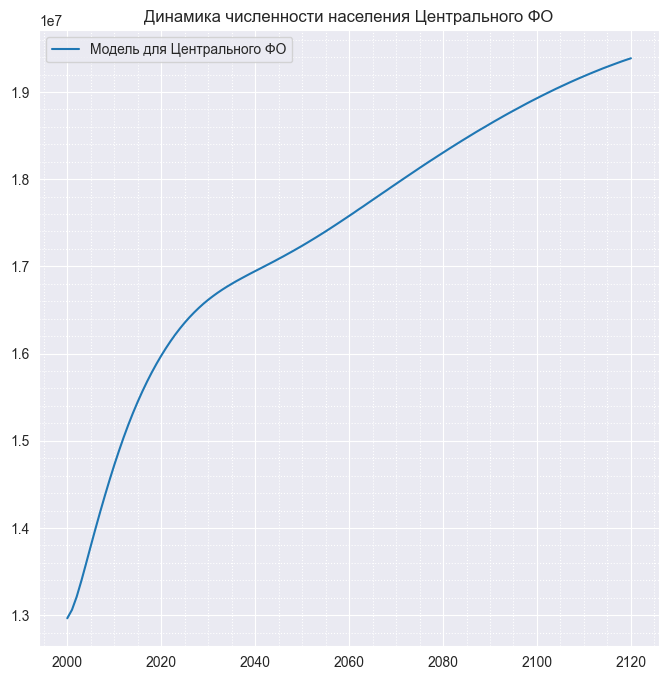

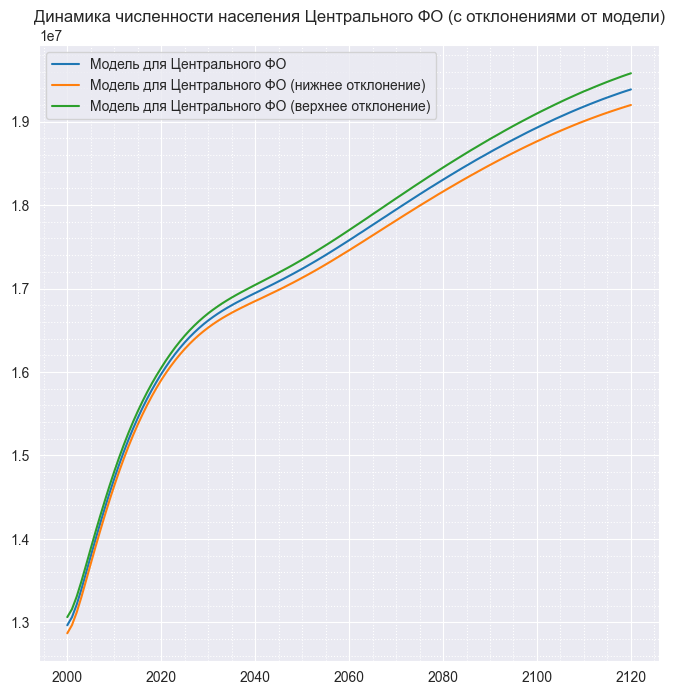

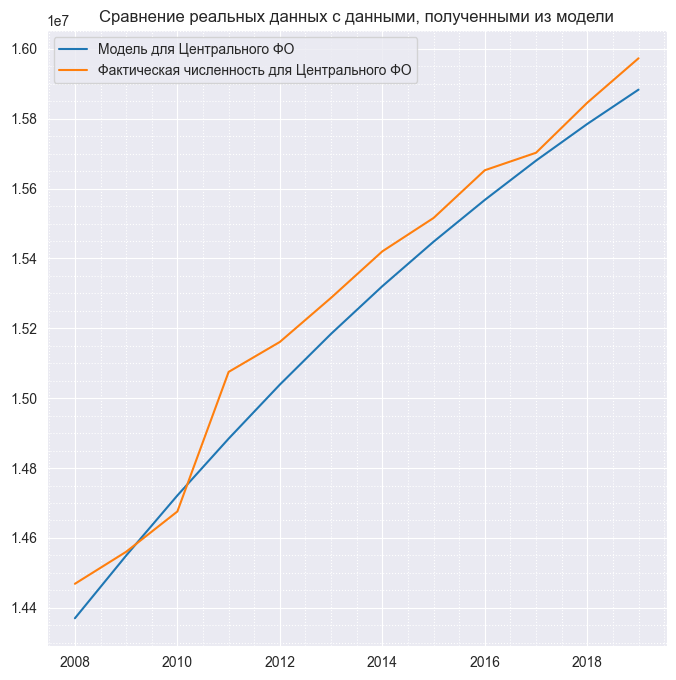

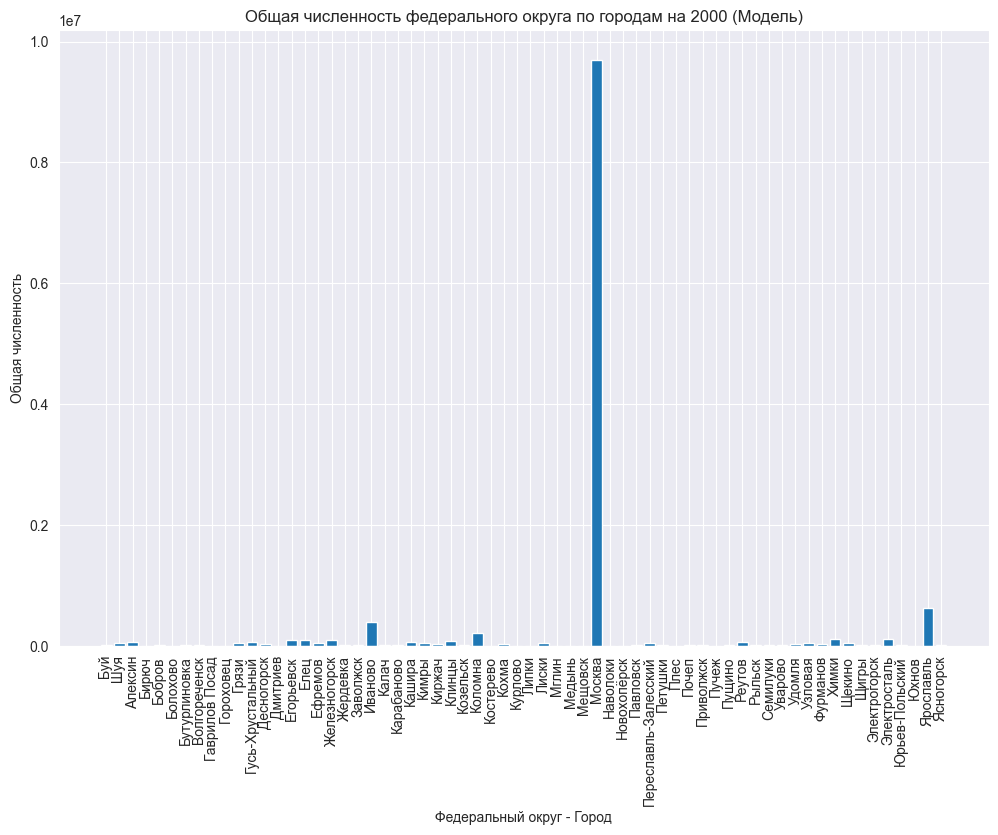

C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\1287862436.py:67: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()


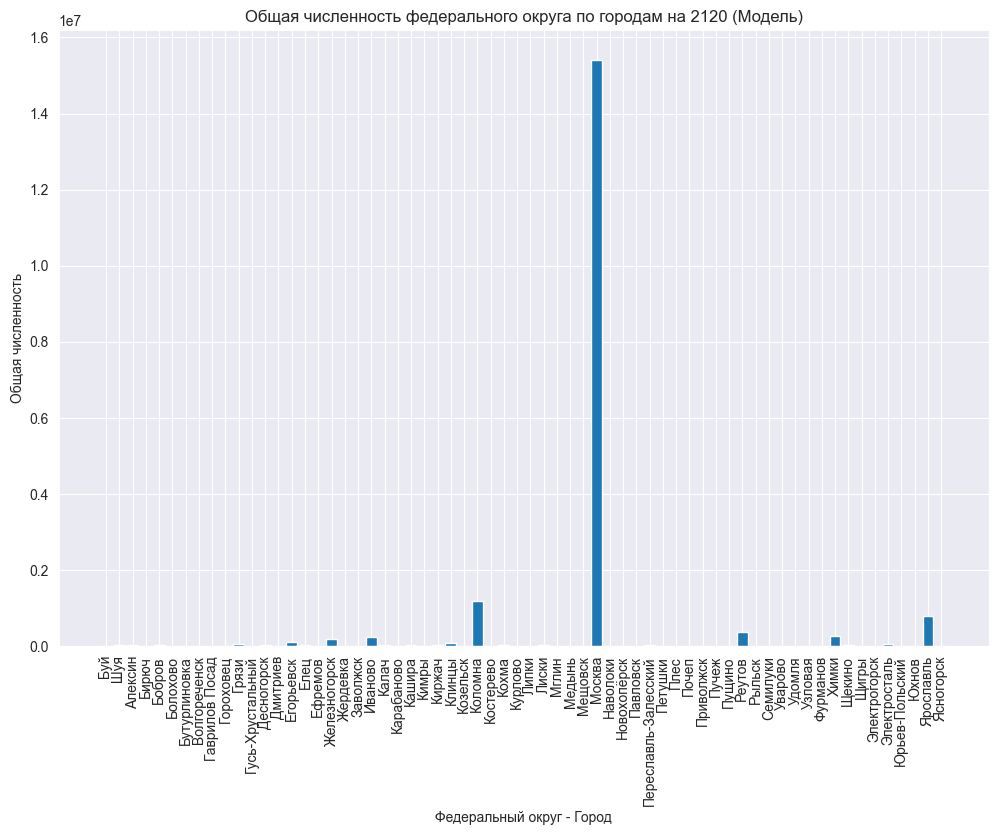

Text(0.5, 1.0, 'Сравнение')

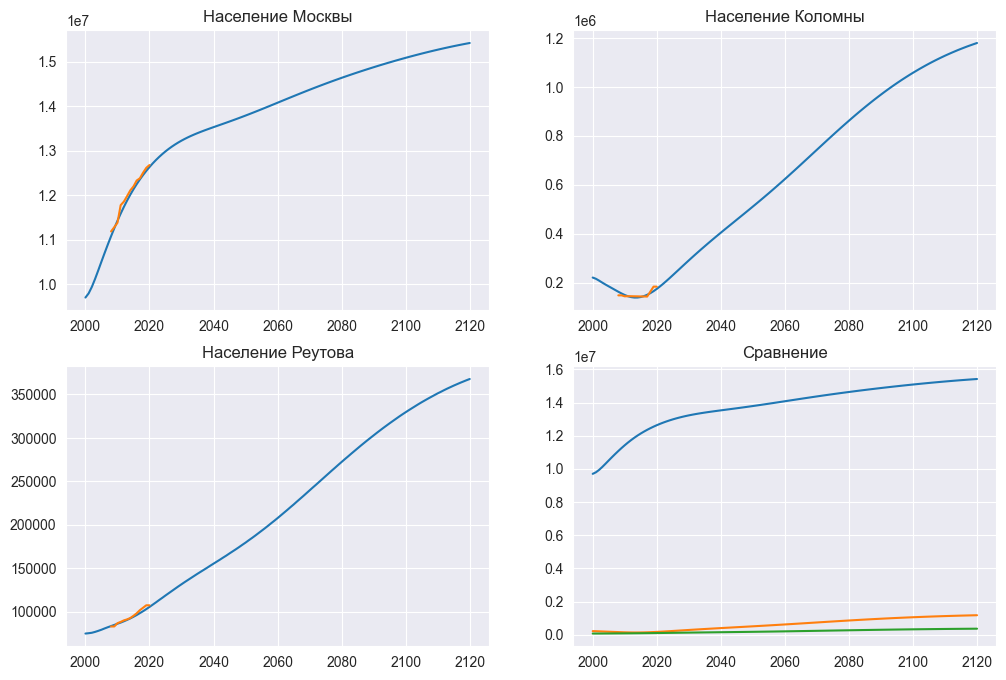

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_2['year'], fdf_2['Модель'], label='Модель для Центрального ФО')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Центрального ФО')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_2['year'], fdf_2['Модель'], label='Модель для Центрального ФО')
ax.plot(fdf_2['year'], fdf_2['Нижняя граница'], label='Модель для Центрального ФО (нижнее отклонение)')
ax.plot(fdf_2['year'], fdf_2['Верхняя граница'], label='Модель для Центрального ФО (верхнее отклонение)')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Центрального ФО (с отклонениями от модели)')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fdf_2_1 = fdf_2.iloc[8:20]
fdf_2_1 = pd.DataFrame(fdf_2_1)
fdf_2_1.head()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_2_1['year'], fdf_2_1['Модель'], label='Модель для Центрального ФО')
ax.plot(fdf_2_1['year'], fdf_2_1['fact'], label='Фактическая численность для Центрального ФО')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Сравнение реальных данных с данными, полученными из модели')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')
import statsmodels.api as sm

#calculate cross correlation
corr = sm.tsa.stattools.ccf(fdf_2_1['Модель'], fdf_2_1['fact'], adjusted=False)
print("Взаимная корреляция: ", corr)



# Выбираем данные для определенного года (например, 2000)
work_df['year'] = pd.to_numeric(work_df['year'], errors='coerce')
work_df['fact'] = work_df['fact'].replace('NA', np.nan)
work_df['fact'] = pd.to_numeric(work_df['fact'], errors='coerce')
work_df['Модель'] = pd.to_numeric(work_df['Модель'], errors='coerce')
work_df['Нижняя граница'] = pd.to_numeric(work_df['Нижняя граница'], errors='coerce')
work_df['Верхняя граница'] = pd.to_numeric(work_df['Верхняя граница'], errors='coerce')
fdf_2_2 = work_df[work_df['federal_district'] == 'Центральный']
# fdf_2_2.info()
year_2000_data = fdf_2_2[fdf_2_2['year'] == 2000]
# year_2000_data.head()
grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2000 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()
# Группировка данных по федеральному округу и городу и подсчет общей численности
year_2120_data = fdf_2_2[fdf_2_2['year'] == 2120]
grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2120 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()


fdf_2_3  = fdf_2_2[fdf_2_2['Город'] == 'Москва']
fdf_2_4  = fdf_2_2[fdf_2_2['Город'] == 'Коломна']
fdf_2_5  = fdf_2_2[fdf_2_2['Город'] == 'Реутов']
# fdf_2_3.head()
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
  
# For Sine Function 
ax[0, 0].plot(fdf_2_3['year'], fdf_2_3['Модель'], label='Модель для Москвы')
ax[0, 0].plot(fdf_2_3['year'], fdf_2_3['fact'], label='Модель для Москвы')
ax[0, 0].set_title("Население Москвы") 
  
# For Cosine Function 
ax[0, 1].plot(fdf_2_4['year'], fdf_2_4['Модель'], label='Модель для Коломны')
ax[0, 1].plot(fdf_2_4['year'], fdf_2_4['fact'], label='Модель для Коломны') 
ax[0, 1].set_title("Население Коломны") 
  
# For Tangent Function 
ax[1, 0].plot(fdf_2_5['year'], fdf_2_5['Модель'], label='Модель для Реутова')
ax[1, 0].plot(fdf_2_5['year'], fdf_2_5['fact'], label='Модель для Реутова') 
ax[1, 0].set_title("Население Реутова") 
  
# For Tanh Function 
ax[1, 1].plot(fdf_2_3['year'], fdf_2_3['Модель'], label='Модель для Москвы') 
ax[1, 1].plot(fdf_2_4['year'], fdf_2_4['Модель'], label='Модель для Коломны') 
ax[1, 1].plot(fdf_2_5['year'], fdf_2_5['Модель'], label='Модель для Реутова') 
ax[1, 1].set_title("Сравнение") 

Данные основаны на модели прогназирования. Поэтому, перед тем, как использовать прогнозные данные, я оценил их с помощью
статистического метода взаимной корреляции. В нашем случае, этот метод может быть использован, т.к. зависимость реальных и прогнозных данных
близка к линейной (это отражает третий график). Первый полученный коэффициент корелляции равен 0,99288346, что говорит о том, что данные тесно связаны и не сдвинуты
между собой. Снижение коэффициента корреляции по мере увиличения лагов как раз и доказывает отсутствие задержки. Следовательно, модель имеет высокую точность прогнозирования.
Максимальное отклонение от прогноза модели составляет 1,03093% (данный процент получается в 2120, там отклонение наибольшее). Отклонения продемонстрированы на втором графике.
    
Теперь проанализируем данные. Динамика численности населения в Центральном федеральном округе носит положительный характер. Доказательство этого представлено на
первом графике. Зависимость похожа на логарифмическую, а это значит, что с каждым новым годом рост постепенно замедляется. Чтобы сделать социально-экономические выводы
нужно решить, какая преследуется задача. Рассмотрим инвестирование. Вкладываться в центральный федеральный округ, например в развитие городской инфраструктуры
(как строительная компания) выгодно на любой срок, т.к. население вырастет примерно в 1,5 раза (наибольшее возможное отклонение составляет 1,03%), как и, соответственно,
спрос на жилые помещения. Однако, т.к рост логарифмический и замедляется со временем, наиболее выгодно рассматривать краткосрочную перспективу и начинать действовать прямо сейчас. Тем более, модель может не учитывать события, которые могут произойти в долгосрочной перспективе и сильно повлиять на численность населения (например, мировую пандемию). 

Важно заметить, что значительный рост будет приходиться на Москву, поэтому нужно оценивать ее как наиболее перспективное место. Такой рост - не выброс данных, полученный
неправильной моделью. Москва изначально доминировала по численности населения (это демонстрирует четвертый график), а функция роста - нелинейная, поэтому такое увелечение
численности. Так же можно выделить Коломну и Реутов: относительно начальной числености они, согласно прогнозам, вырастут в 6 и 7 раз соответсвенно. Демонстрация представлена 
на 6 графике.

Если же оценивать демографические параметры, то в данном регионе рождаемость предобладет на смертностью, что может говорить о высоком качестве здравоохранения.

Взаимная корреляция:  [ 0.98325825  0.71822049  0.47132274  0.25369667  0.0574095  -0.1027713
 -0.23061227 -0.31982906 -0.36358127 -0.37455472 -0.3472876  -0.18317114]


C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\626721638.py:54: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()


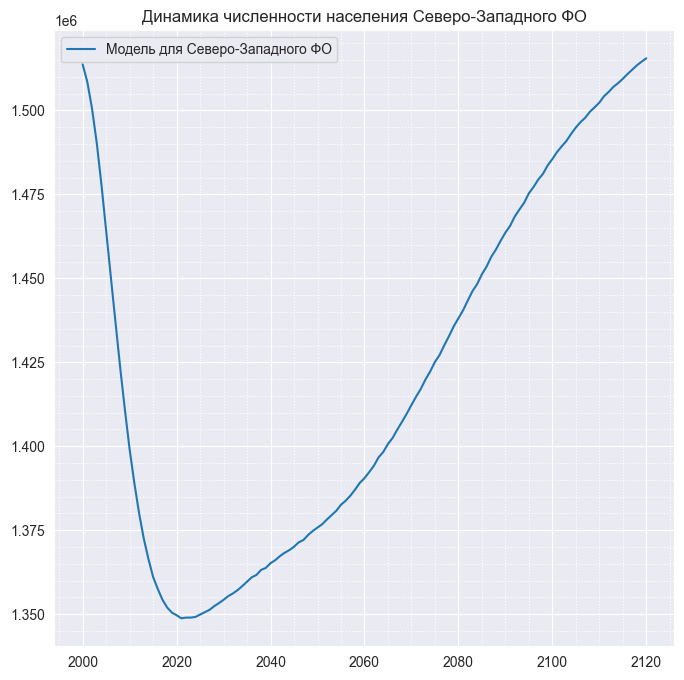

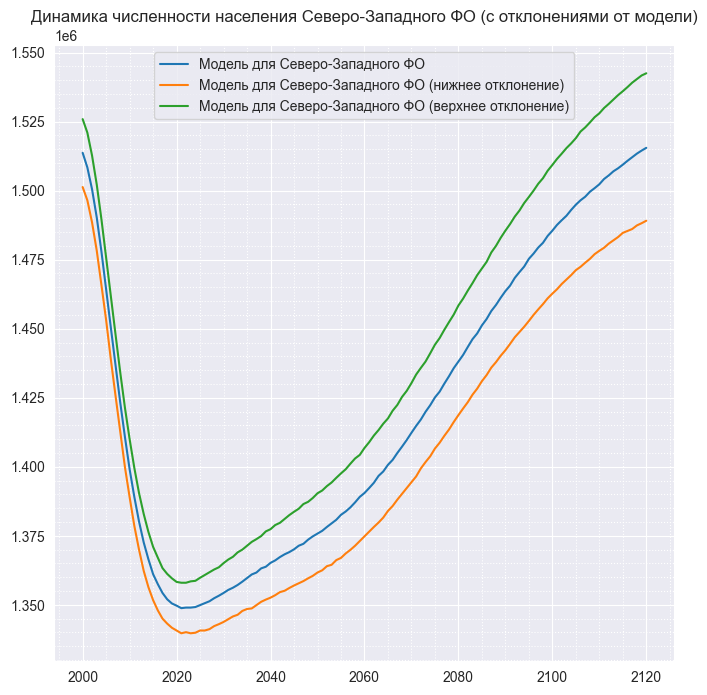

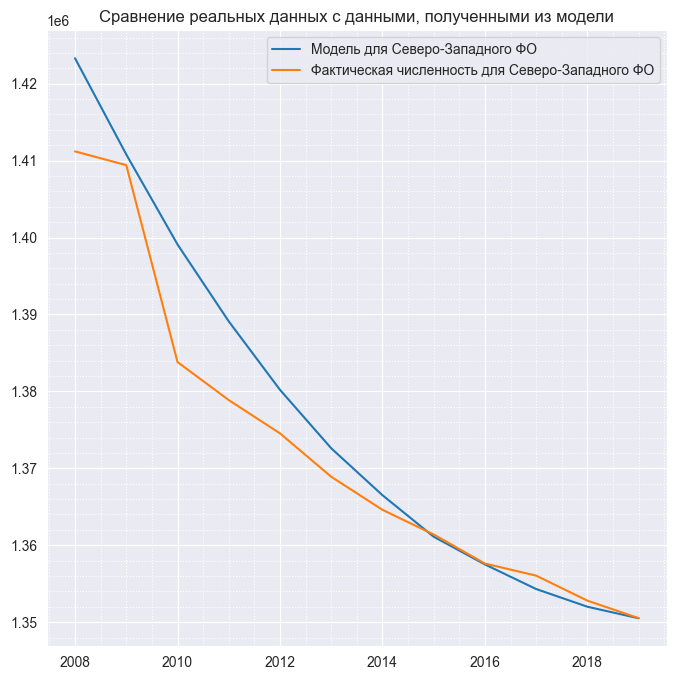

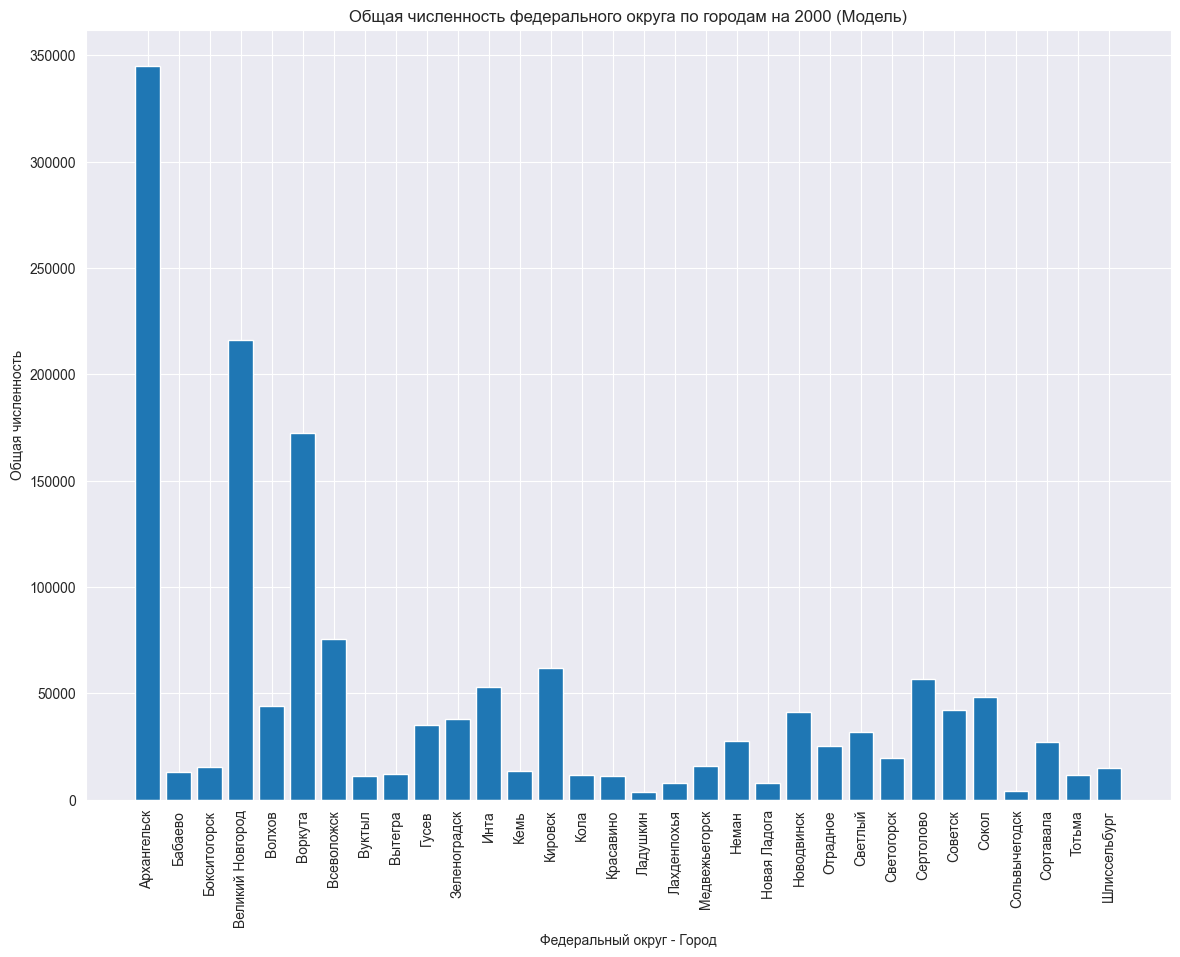

C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\626721638.py:67: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()


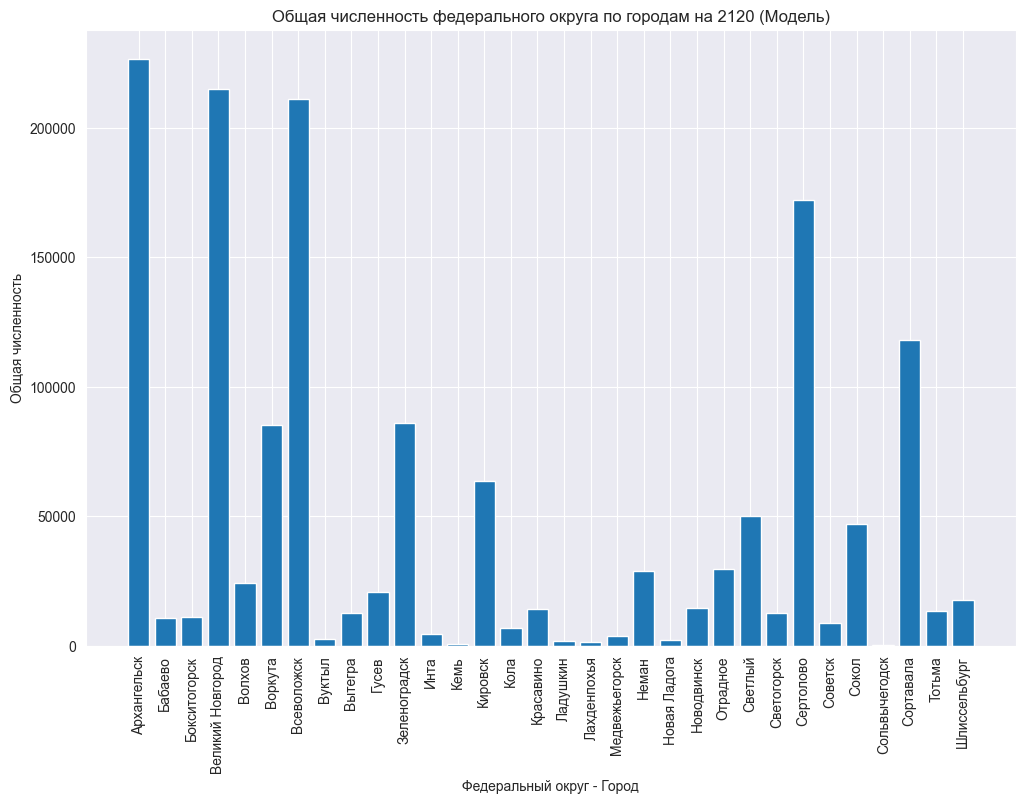

C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\626721638.py:79: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2000_data.groupby(['federal_district', 'region']).sum().reset_index()


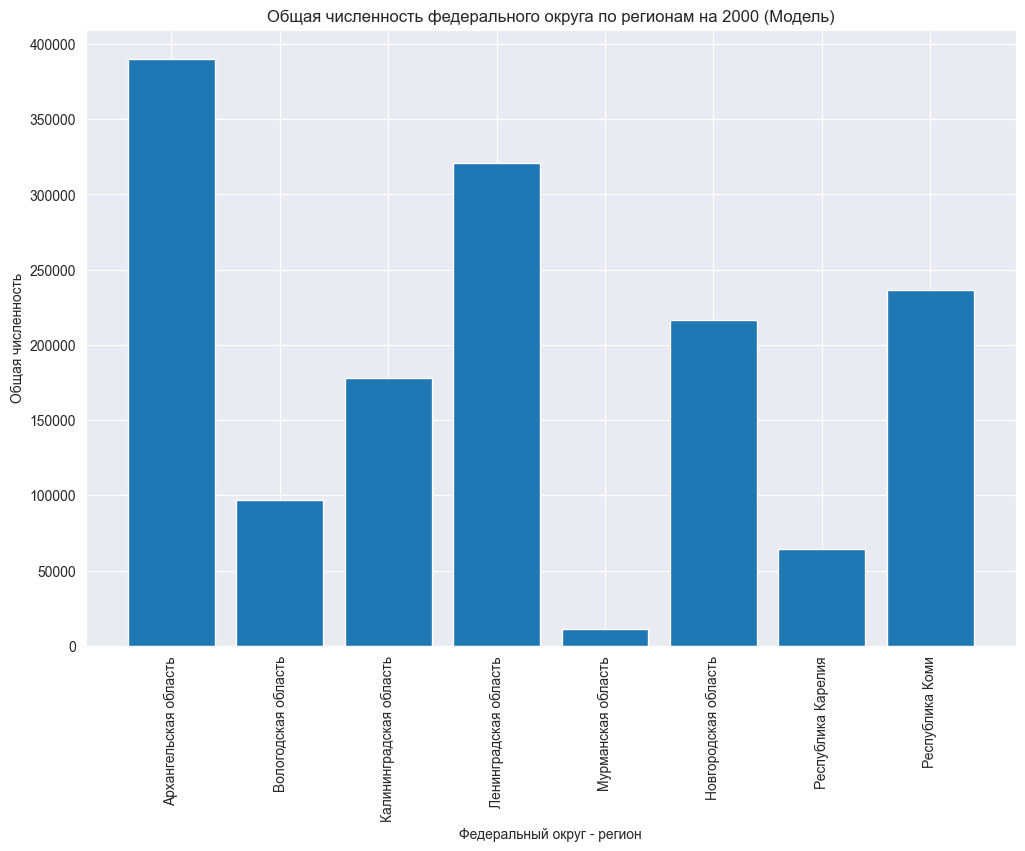

C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\626721638.py:89: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2120_data.groupby(['federal_district', 'region']).sum().reset_index()


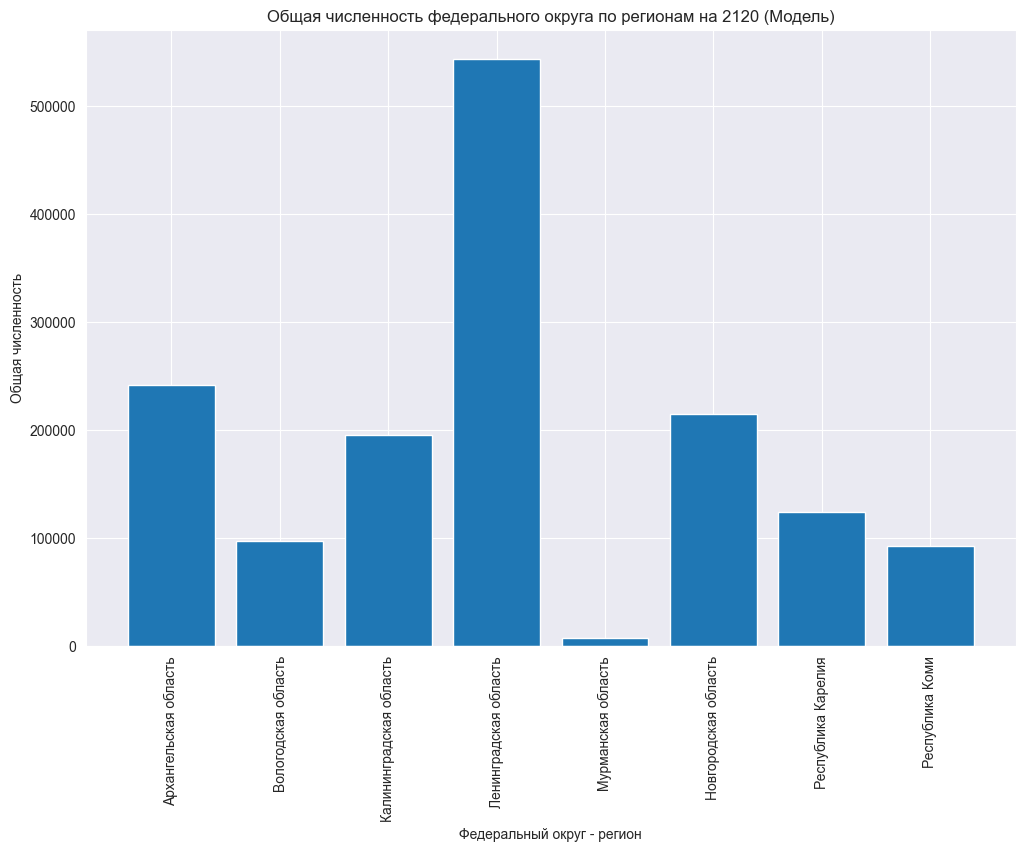

Text(0.5, 1.0, 'Сравнение городов Лен. области и Архангельска')

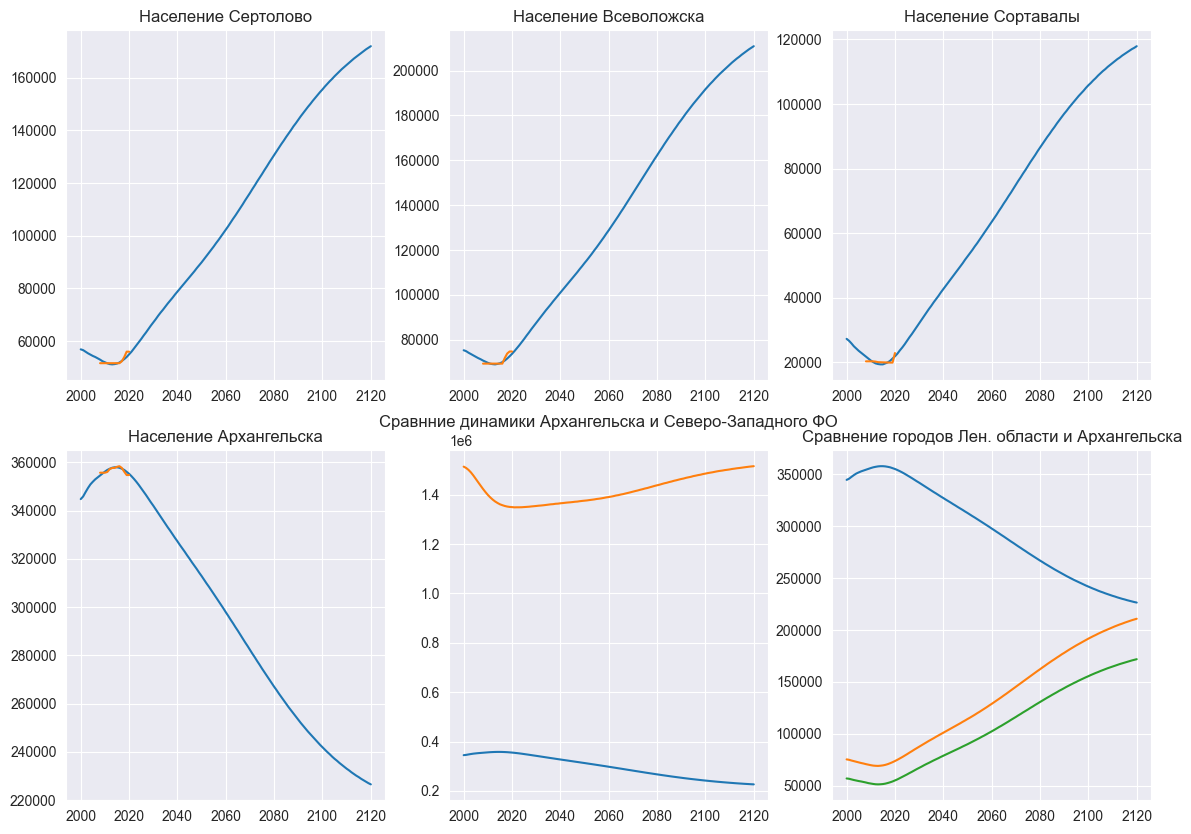

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_3['year'], fdf_3['Модель'], label='Модель для Северо-Западного ФО')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Северо-Западного ФО')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_3['year'], fdf_3['Модель'], label='Модель для Северо-Западного ФО')
ax.plot(fdf_3['year'], fdf_3['Нижняя граница'], label='Модель для Северо-Западного ФО (нижнее отклонение)')
ax.plot(fdf_3['year'], fdf_3['Верхняя граница'], label='Модель для Северо-Западного ФО (верхнее отклонение)')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Северо-Западного ФО (с отклонениями от модели)')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fdf_3_1 = fdf_3.iloc[8:20]
fdf_3_1 = pd.DataFrame(fdf_3_1)
fdf_3_1.head()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_3_1['year'], fdf_3_1['Модель'], label='Модель для Северо-Западного ФО')
ax.plot(fdf_3_1['year'], fdf_3_1['fact'], label='Фактическая численность для Северо-Западного ФО')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Сравнение реальных данных с данными, полученными из модели')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')
import statsmodels.api as sm

#calculate cross correlation
corr = sm.tsa.stattools.ccf(fdf_3_1['Модель'], fdf_3_1['fact'], adjusted=False)
print("Взаимная корреляция: ", corr)



# Выбираем данные для определенного года (например, 2000)
work_df['year'] = pd.to_numeric(work_df['year'], errors='coerce')
work_df['fact'] = work_df['fact'].replace('NA', np.nan)
work_df['fact'] = pd.to_numeric(work_df['fact'], errors='coerce')
work_df['Модель'] = pd.to_numeric(work_df['Модель'], errors='coerce')
work_df['Нижняя граница'] = pd.to_numeric(work_df['Нижняя граница'], errors='coerce')
work_df['Верхняя граница'] = pd.to_numeric(work_df['Верхняя граница'], errors='coerce')
fdf_3_2 = work_df[work_df['federal_district'] == 'Северо-Западный']
# fdf_3_2.info()
year_2000_data = fdf_3_2[fdf_3_2['year'] == 2000]
# year_2000_data.head()
grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(14, 10))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2000 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()
# Группировка данных по федеральному округу и городу и подсчет общей численности
year_2120_data = fdf_3_2[fdf_3_2['year'] == 2120]
grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2120 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()

grouped_df = year_2000_data.groupby(['federal_district', 'region']).sum().reset_index()
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['region']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по регионам на 2000 (Модель)')
plt.xlabel('Федеральный округ - регион')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()

grouped_df = year_2120_data.groupby(['federal_district', 'region']).sum().reset_index()
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['region']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по регионам на 2120 (Модель)')
plt.xlabel('Федеральный округ - регион')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()


fdf_3_3  = fdf_3_2[fdf_3_2['Город'] == 'Архангельск']
fdf_3_4  = fdf_3_2[fdf_3_2['Город'] == 'Всеволожск']
fdf_3_5  = fdf_3_2[fdf_3_2['Город'] == 'Сортавала']
fdf_3_6  = fdf_3_2[fdf_3_2['Город'] == 'Сертолово']


fig, ax = plt.subplots(2, 3, figsize=(14, 10))
  

ax[0, 0].plot(fdf_3_6['year'], fdf_3_6['Модель'], label='Модель для Сертолово')
ax[0, 0].plot(fdf_3_6['year'], fdf_3_6['fact'], label='Модель для Сертолово')
ax[0, 0].set_title("Население Сертолово") 
  

ax[0, 1].plot(fdf_3_4['year'], fdf_3_4['Модель'], label='Модель для Всеволожска')
ax[0, 1].plot(fdf_3_4['year'], fdf_3_4['fact'], label='Модель для Всеволожска') 
ax[0, 1].set_title("Население Всеволожска") 
  
ax[0, 2].plot(fdf_3_5['year'], fdf_3_5['Модель'], label='Модель для Сортавалы')
ax[0, 2].plot(fdf_3_5['year'], fdf_3_5['fact'], label='Модель для Сортавалы') 
ax[0, 2].set_title("Население Сортавалы") 

ax[1, 0].plot(fdf_3_3['year'], fdf_3_3['Модель'], label='Модель для Архангельска')
ax[1, 0].plot(fdf_3_3['year'], fdf_3_3['fact'], label='Модель для Архангельска') 
ax[1, 0].set_title("Население Архангельска") 

ax[1, 1].plot(fdf_3_3['year'], fdf_3_3['Модель'], label='Модель для Архангельска')
ax[1, 1].plot(fdf_3['year'], fdf_3['Модель'], label='Модель для Северо-Западного ФО')
ax[1, 1].set_title("Сравнние динамики Архангельска и Северо-Западного ФО") 
  

ax[1, 2].plot(fdf_3_3['year'], fdf_3_3['Модель'], label='Модель для Архангельска')
ax[1, 2].plot(fdf_3_4['year'], fdf_3_4['Модель'], label='Модель для Всеволожска')
ax[1, 2].plot(fdf_3_6['year'], fdf_3_6['Модель'], label='Модель для Сертолово')
ax[1, 2].set_title("Сравнение городов Лен. области и Архангельска") 


Данные основаны на модели прогназирования. Поэтому, я также оценил их с помощью взаимной корреляционной функции. Это возможно, т.к. зависимость линейная (третий график).Коэффициент кореляции равен 0.98325825, следовательно модель сделала статистический прогноз достаточно точно. Наибольшее отклонение наблюдается в 2120 году и составляет 
1,67785%. Отклонение продемонстрировано на втором графике.

Общая динамика численности Северо-Восточного ФО неодназначная. Значение числености пораболически падает к 2020 году, а затем экспоненциально растет к 2120. Это отражено на первом графике. Выделим также задачу инвестирования, чтобы сделать экономические выводы. Сравнивавая четвертый и пятый графики, можно сделать вывод, что далеко не все города Северо-Западного ФО экспоненциально увеличили свою численность. Шестой и седьмой графики доказывают, что в действительности весь рост пришелся на города Ленинградской области и Республики Корелия. В отношение Ленинградской области существует зависимость: чем ближе город к Санкт-Петербургу, тем сильнее растет численность. Вероятно, это связано с маятниковой миграцией: люди работают в Санкт-Петербурге, а проживают в ближайших городах области. Поэтому достаточно выгодно инвестировать в инфраструктуру Ленинградской области на любой срок, т.к. рост населения экспоненциальный (особенно в города Всеволожск и Сертолово).

Как представлено на четвертом, пятом, шестом и седьмом графиках население Архангелской области и самого Архангелька, на основе прогноза, будет снижаться. Скорее всего, люди покидают Архангельскую область и мигрируют в крупные города. А сама миграция связана с отсутствием рабочих мест в данном регионе. Чтобы замедлить или даже остановить снижение населения, Мунициполитет Архангельской области или органы местного самоуправления должны способствовать увелечению числа рабочих мест.

Взаимная корреляция:  [ 0.98613636  0.72029432  0.47479755  0.23306759  0.02089528 -0.15083504
 -0.27678946 -0.34706752 -0.37060059 -0.35889521 -0.31479422 -0.15979378]


C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\92875203.py:54: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()


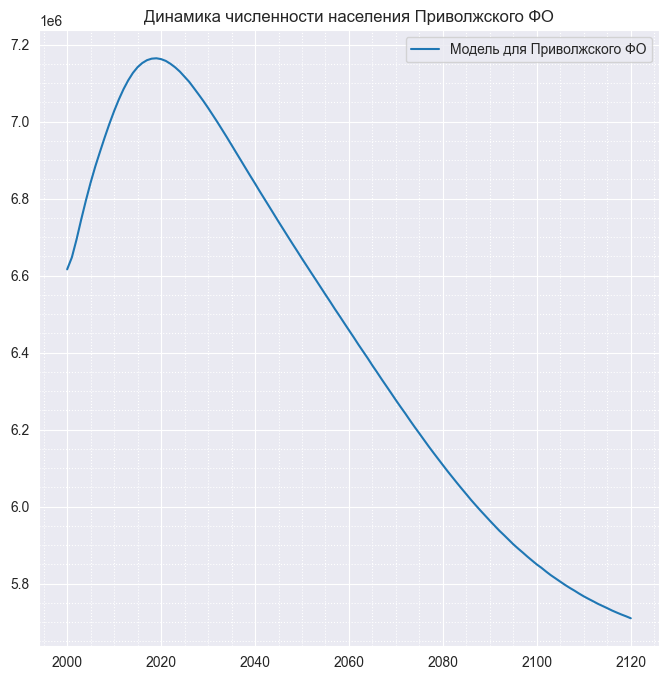

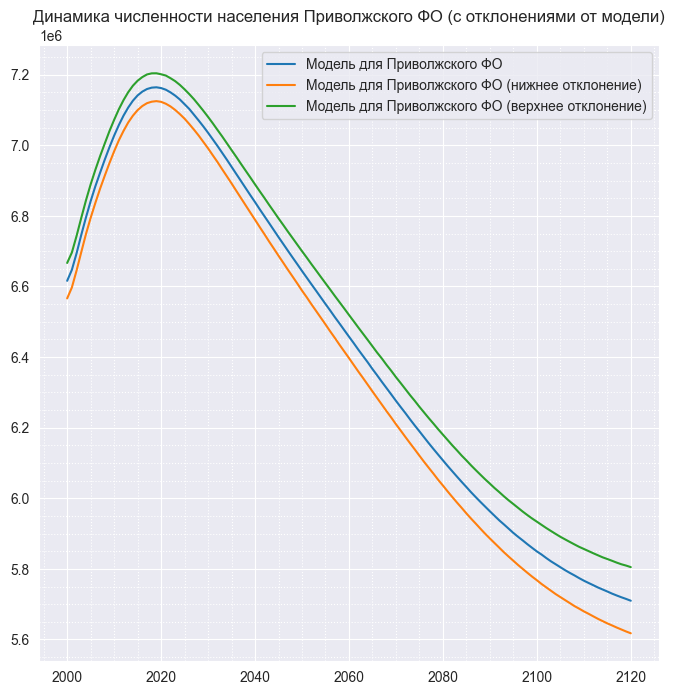

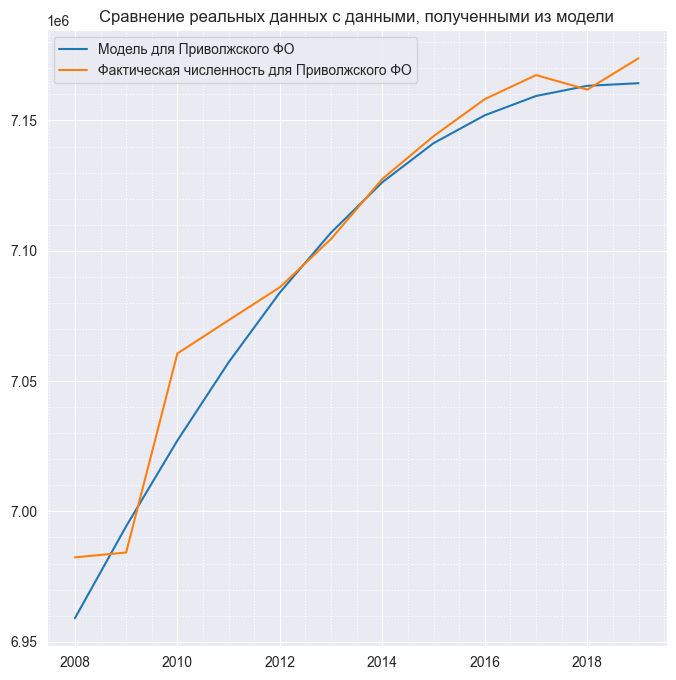

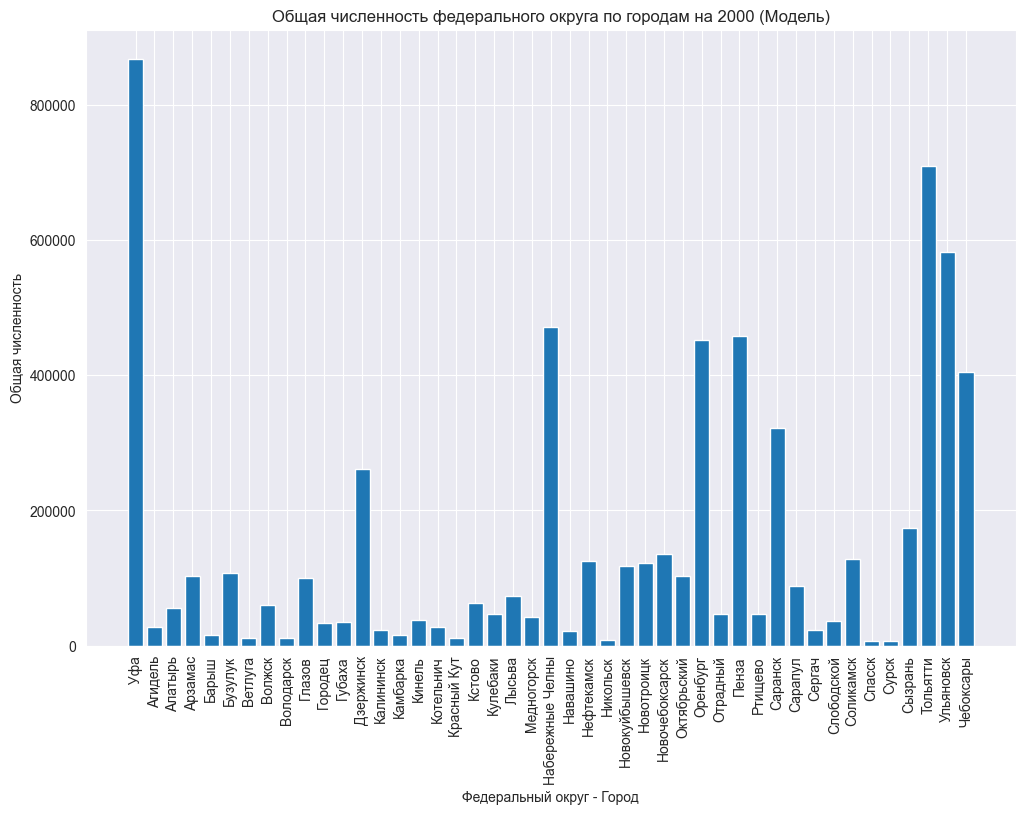

C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\92875203.py:67: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()


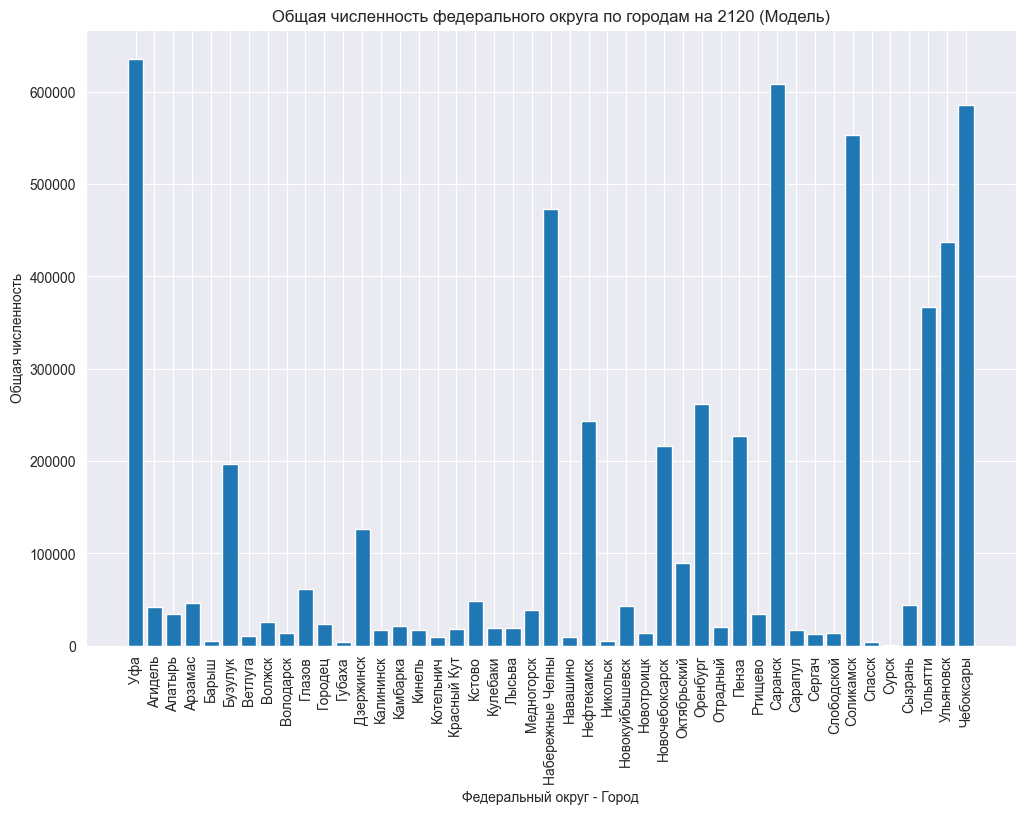

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_4['year'], fdf_4['Модель'], label='Модель для Приволжского ФО')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Приволжского ФО')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_4['year'], fdf_4['Модель'], label='Модель для Приволжского ФО')
ax.plot(fdf_4['year'], fdf_4['Нижняя граница'], label='Модель для Приволжского ФО (нижнее отклонение)')
ax.plot(fdf_4['year'], fdf_4['Верхняя граница'], label='Модель для Приволжского ФО (верхнее отклонение)')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Приволжского ФО (с отклонениями от модели)')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fdf_4_1 = fdf_4.iloc[8:20]
fdf_4_1 = pd.DataFrame(fdf_4_1)
fdf_4_1.head()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_4_1['year'], fdf_4_1['Модель'], label='Модель для Приволжского ФО')
ax.plot(fdf_4_1['year'], fdf_4_1['fact'], label='Фактическая численность для Приволжского ФО')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Сравнение реальных данных с данными, полученными из модели')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')
import statsmodels.api as sm

#calculate cross correlation
corr = sm.tsa.stattools.ccf(fdf_4_1['Модель'], fdf_4_1['fact'], adjusted=False)
print("Взаимная корреляция: ", corr)



# Выбираем данные для определенного года (например, 2000)
work_df['year'] = pd.to_numeric(work_df['year'], errors='coerce')
work_df['fact'] = work_df['fact'].replace('NA', np.nan)
work_df['fact'] = pd.to_numeric(work_df['fact'], errors='coerce')
work_df['Модель'] = pd.to_numeric(work_df['Модель'], errors='coerce')
work_df['Нижняя граница'] = pd.to_numeric(work_df['Нижняя граница'], errors='coerce')
work_df['Верхняя граница'] = pd.to_numeric(work_df['Верхняя граница'], errors='coerce')
fdf_4_2 = work_df[work_df['federal_district'] == 'Приволжский']
# fdf_3_2.info()
year_2000_data = fdf_4_2[fdf_4_2['year'] == 2000]
# year_2000_data.head()
grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2000 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()
# Группировка данных по федеральному округу и городу и подсчет общей численности
year_2120_data = fdf_4_2[fdf_4_2['year'] == 2120]
grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2120 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()

Данные основаны на модели прогназирования, поэтому аналогичным образом я оценил их с помощью статистического метода взаимной корреляции. Зависимость реальных и прогнозных данных также близка к линейной (это отражает третий график). Первый полученный коэффициент корелляции равен 0.98613636, что говорит о том, что данные тесно связаны и не сдвинуты между собой. Следовательно, модель имеет высокую точность прогнозирования. Максимальное отклонение от прогноза модели составляет 1,75439% (данный процент получается в 2120, там отклонение наибольшее). Отклонения продемонстрированы на втором графике.

Динамика населения для Приволжского ФО, начиная с 2020 года, получается отрицательная. Функция (после 2020) приближена к логарифмической. С точки зрения инфестирования в инфраструктуру Привожского ФО это совсем не выгодно, т.к. падение численнности населения пораждает падение спроса. На графиках четыре и пять можно заметить, что отдельные города выросли. Однако другие города упали на большее значение. Это связано с тем, что помимо оттока, население просто перераспределилось между городами Приволжского ФО, и это рост численности отдельных городов никак не влияет на развитие экономической составляющей.

Важно заметить, что до падения, шел активный рост численности населения (первый график). Вероятно, отток населения прогнозируется в связи с трудовой миграцией. Людей не устраивают рабочие места в своих городах, и они переезжают в другие. Это как раз также и доказывает перераспределение между городами внутри Приволжского ФО. Чтобы замедлить населения, органы местного самоуправления должны способствовать увелечению числа рабочих мест.

Взаимная корреляция:  [ 0.04626211 -0.39567812 -0.66333981 -0.5928115  -0.3164156   0.0372059
  0.33720278  0.46041307  0.40416556  0.1451494  -0.16432659 -0.10615101]
Коэффициент корреляции Спирмена: -0.350879352911252
Коэффициент корреляции Кендалла: -0.24618298195866545


C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\2758313842.py:59: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2011_data.groupby(['federal_district', 'Город']).sum().reset_index()


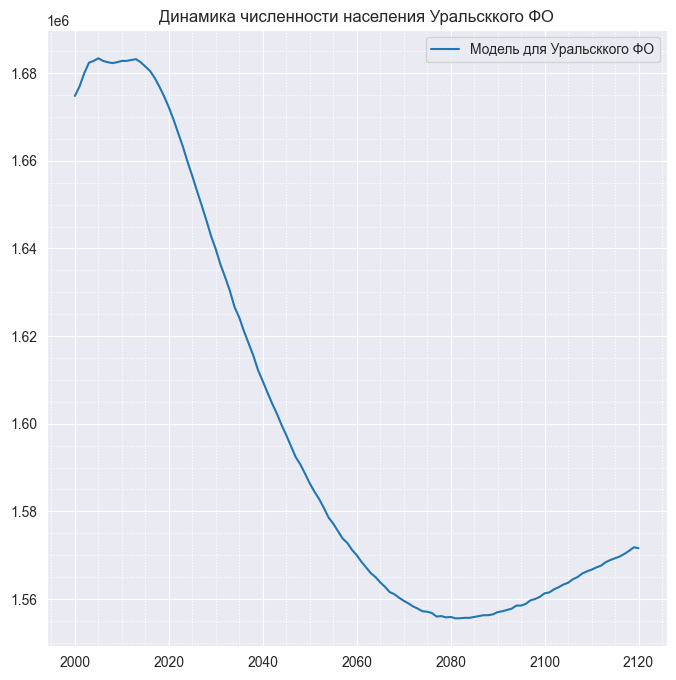

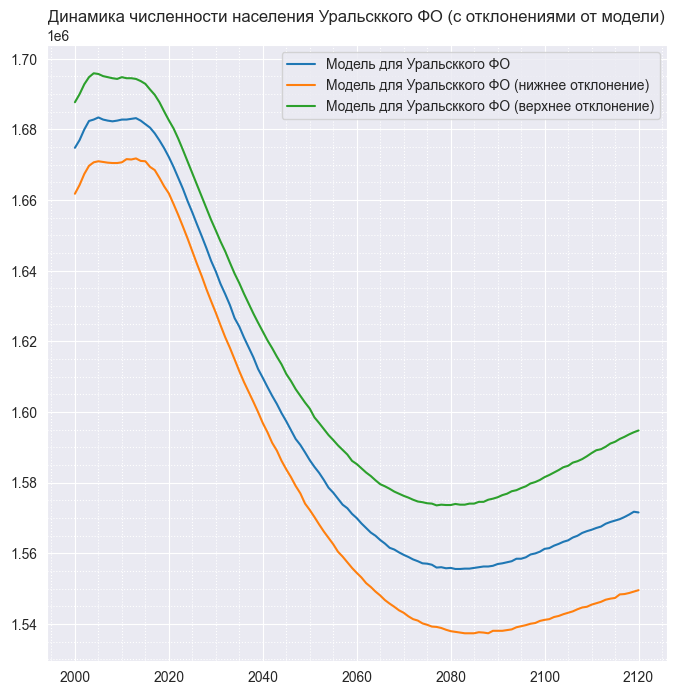

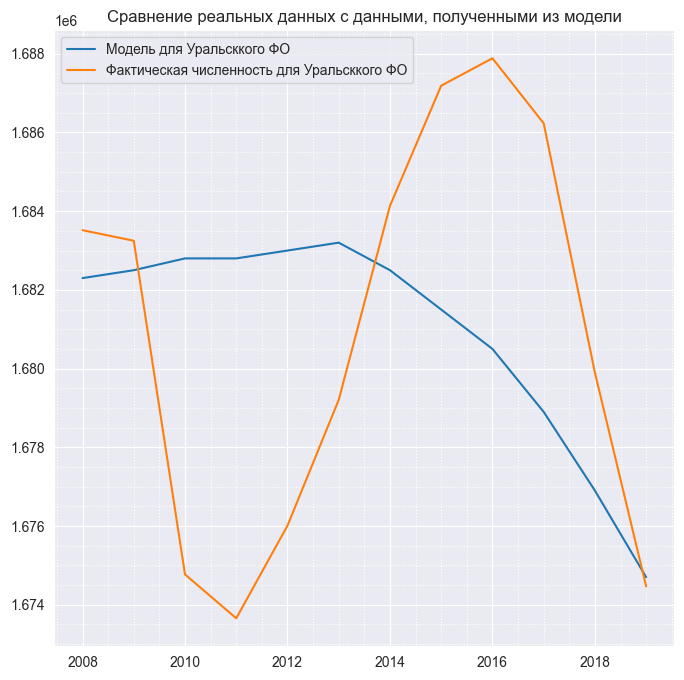

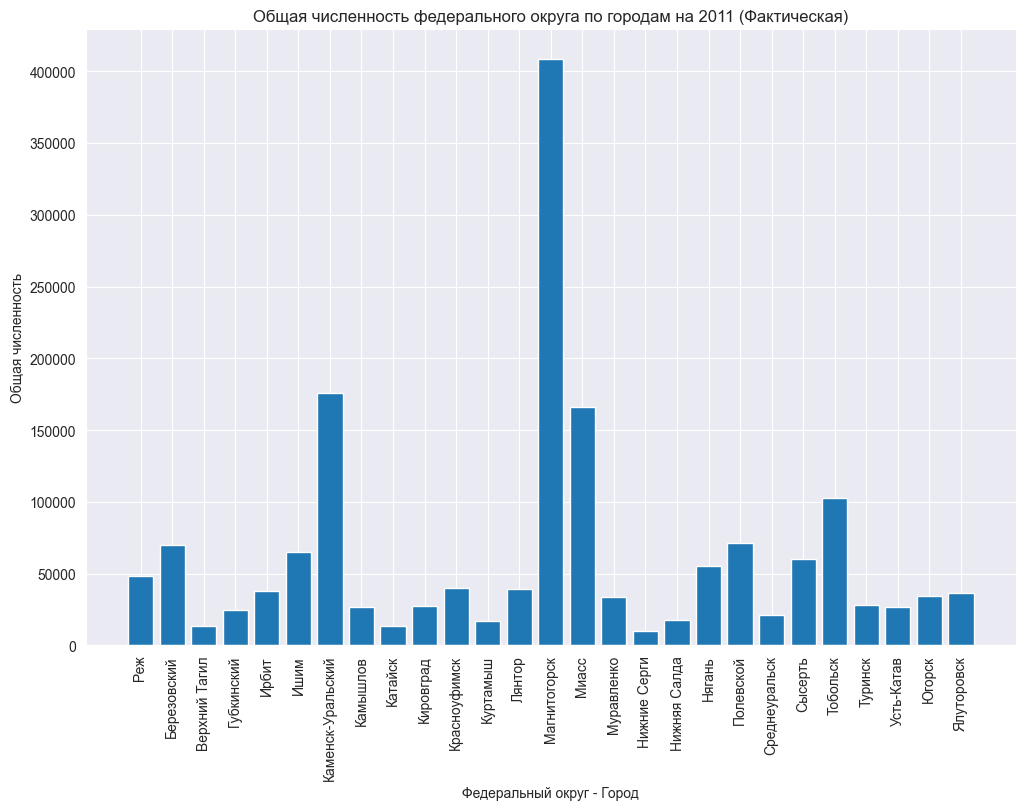

C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\2758313842.py:71: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df_1 = year_2016_data.groupby(['federal_district', 'Город']).sum().reset_index()


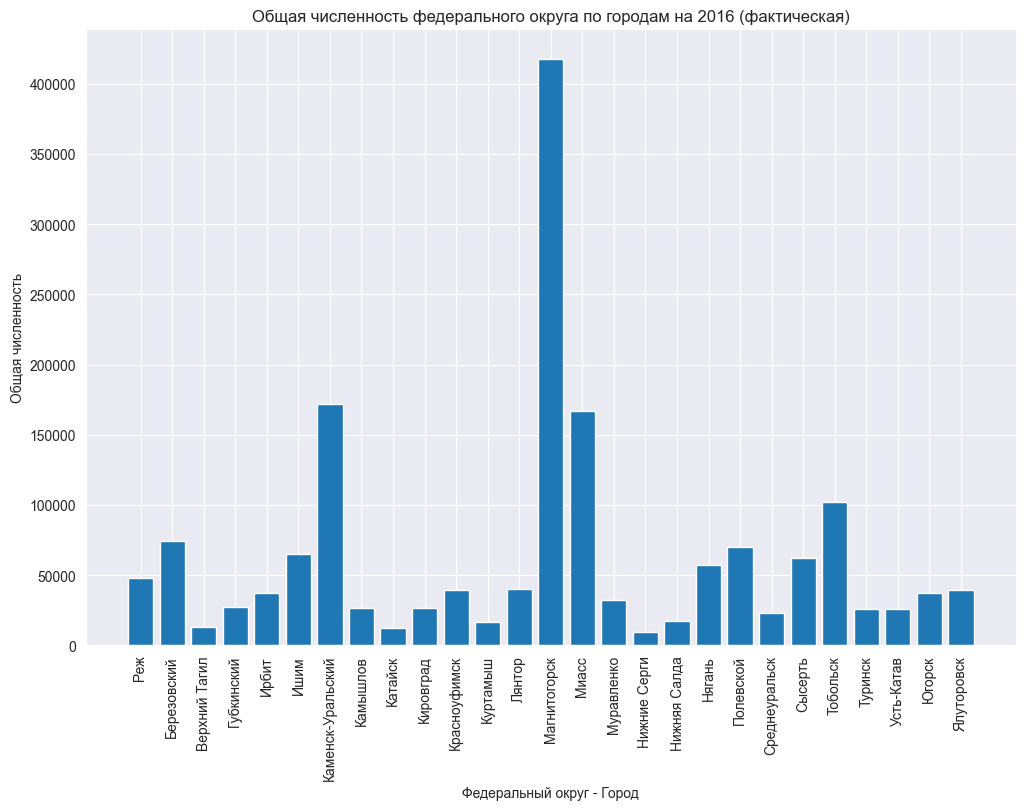

C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\2758313842.py:84: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()


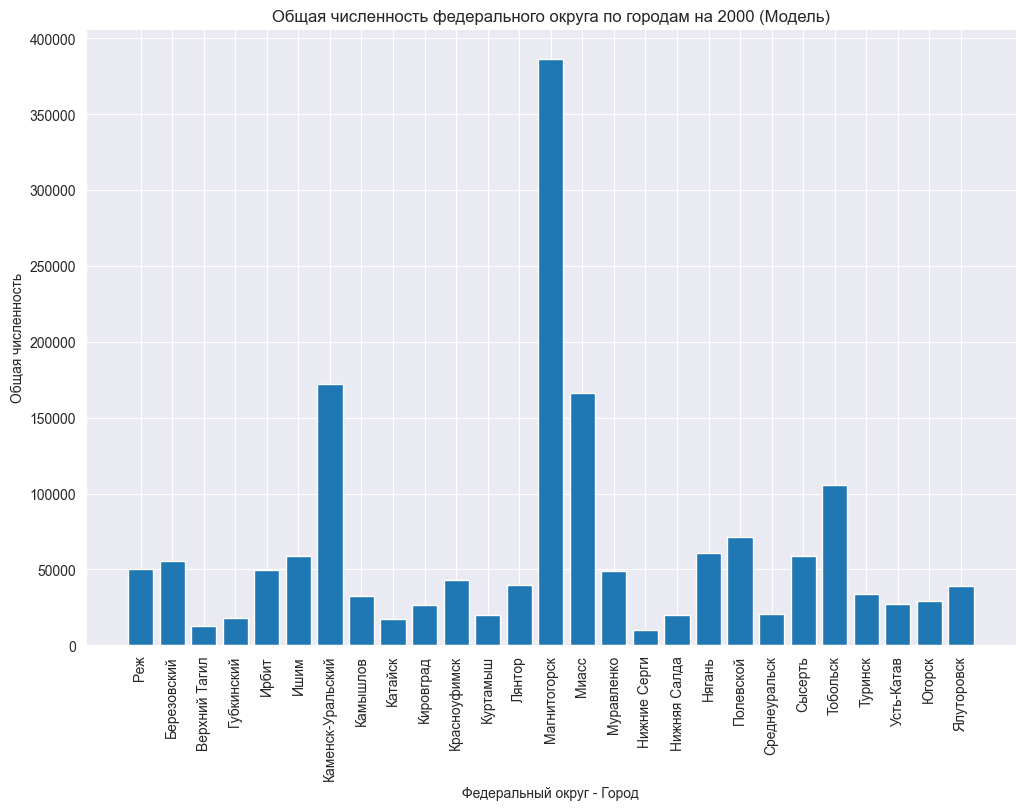

C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\2758313842.py:97: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()


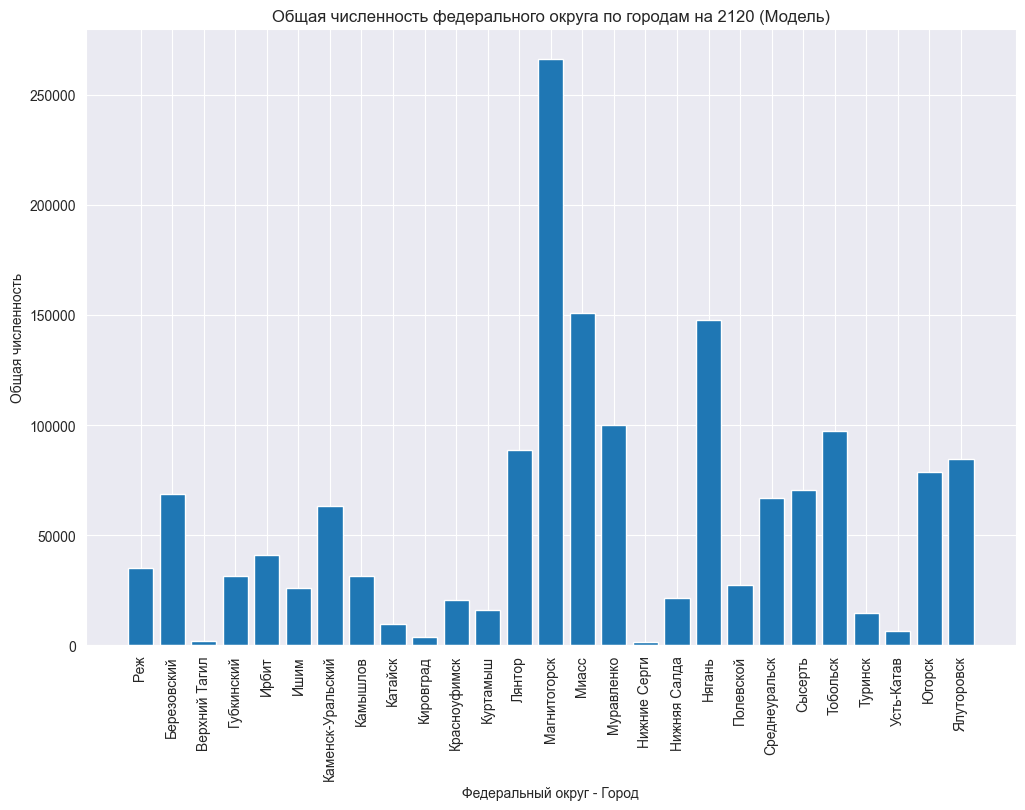

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_5['year'], fdf_5['Модель'], label='Модель для Уральсккого ФО')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Уральсккого ФО')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_5['year'], fdf_5['Модель'], label='Модель для Уральсккого ФО')
ax.plot(fdf_5['year'], fdf_5['Нижняя граница'], label='Модель для Уральсккого ФО (нижнее отклонение)')
ax.plot(fdf_5['year'], fdf_5['Верхняя граница'], label='Модель для Уральсккого ФО (верхнее отклонение)')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Уральсккого ФО (с отклонениями от модели)')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fdf_5_1 = fdf_5.iloc[8:20]
fdf_5_1 = pd.DataFrame(fdf_5_1)
fdf_5_1.head()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_5_1['year'], fdf_5_1['Модель'], label='Модель для Уральсккого ФО')
ax.plot(fdf_5_1['year'], fdf_5_1['fact'], label='Фактическая численность для Уральсккого ФО')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Сравнение реальных данных с данными, полученными из модели')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

import statsmodels.api as sm
corr = sm.tsa.stattools.ccf(fdf_5_1['Модель'], fdf_5_1['fact'], adjusted=False)
print("Взаимная корреляция: ", corr)

from scipy.stats import spearmanr
correlation, p_value = spearmanr(fdf_5_1['Модель'], fdf_5_1['fact'])
print("Коэффициент корреляции Спирмена:", correlation)
from scipy.stats import kendalltau
correlation, p_value = kendalltau(fdf_5_1['Модель'], fdf_5_1['fact'])
print("Коэффициент корреляции Кендалла:", correlation)


# Выбираем данные для определенного года (например, 2000)
work_df['year'] = pd.to_numeric(work_df['year'], errors='coerce')
work_df['fact'] = work_df['fact'].replace('NA', np.nan)
work_df['fact'] = pd.to_numeric(work_df['fact'], errors='coerce')
work_df['Модель'] = pd.to_numeric(work_df['Модель'], errors='coerce')
work_df['Нижняя граница'] = pd.to_numeric(work_df['Нижняя граница'], errors='coerce')
work_df['Верхняя граница'] = pd.to_numeric(work_df['Верхняя граница'], errors='coerce')
fdf_5_2 = work_df[work_df['federal_district'] == 'Уральский']
# fdf_3_2.info()

year_2011_data = fdf_5_2[fdf_5_2['year'] == 2011]
grouped_df = year_2011_data.groupby(['federal_district', 'Город']).sum().reset_index()
# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['fact'])
plt.title('Общая численность федерального округа по городам на 2011 (Фактическая)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()

year_2016_data = fdf_5_2[fdf_5_2['year'] == 2016]
grouped_df_1 = year_2016_data.groupby(['federal_district', 'Город']).sum().reset_index()
# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df_1['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df_1['fact'])
plt.title('Общая численность федерального округа по городам на 2016 (фактическая)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()

year_2000_data = fdf_5_2[fdf_5_2['year'] == 2000]
# year_2000_data.head()
grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2000 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()
# Группировка данных по федеральному округу и городу и подсчет общей численности
year_2120_data = fdf_5_2[fdf_5_2['year'] == 2120]
grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2120 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()

Данные основаны на модели прогназирования, поэтому аналогичным образом я оценил их с помощью статистического метода взаимной корреляции. Однако зависимость реальных данных от прогнозных нелинейная, поэтому классический коэфициент корреляции не работает. Я применил еще два: коэффициент корреляции Спирмена и коэффициент корреляции Кендалла. Они позволят обнаружить нелинейную зависимость. Однако, результаты говорят об отсутствии связи (-0,350879352911252 - корреляциия Спирмена, корреляция Кендалла: -0,24618298195866545).
Зависимость данных других ФО до этого была тесно связана, а с этим ФО - нет. Хотя тип данных не изменился. Скорее всего, в фактических данных есть резкое возрастание населения какого-то конкретного города. Для этого я создал два графика для фактической численности 2011 года и 2016 года. Действительно, учитывая, что общая численность населения для федерального округа небольшая, увелечение численности Магнитогорска дает резкое увелечение для данных округа. Модель же аппроксимирует зависимость. Поэтому можно сказать, что модель все равно дает относительно точные предсказания. Максимальное отклонение от прогноза модели составляет 1,21251% (данный процент получается в 2120, там отклонение наибольшее). Отклонения продемонстрированы на втором графике.

На самао деле, общая зависимость для данного ФО почти не отличается от зависимости для Приволжского ведерального округа. Поэтому все социально-экономические выводы для Приволжского ФО подходят и для этих данных.


Взаимная корреляция:  [ 0.76939051  0.41938281  0.13027852 -0.08691144 -0.22901644 -0.3023332
 -0.31811218 -0.29597114 -0.25112881 -0.19212714 -0.1420923  -0.06982681]
Взаимная корреляция данных по Гудермесу:  [-0.30886796 -0.43834192 -0.50994989 -0.4831272  -0.37403433 -0.21456422
 -0.04448014  0.09413404  0.1627085   0.19387872  0.17891701  0.11408297]
Коэффициент корреляции Спирмена: -0.15227389460052784
Коэффициент корреляции Кендалла: -0.1973855084879307


C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\1718423699.py:91: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()


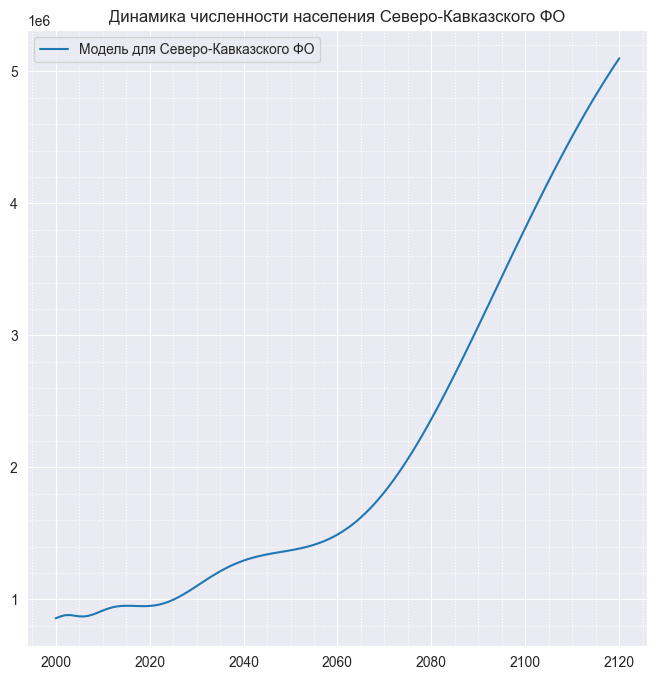

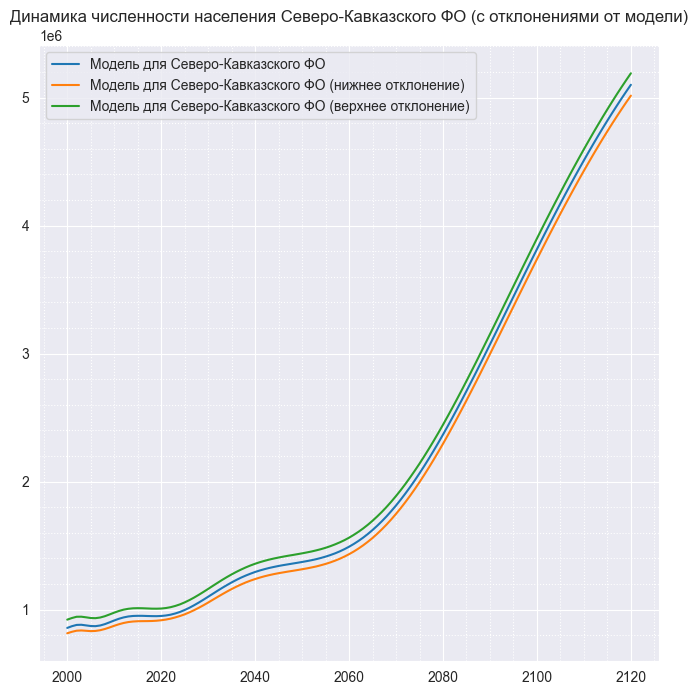

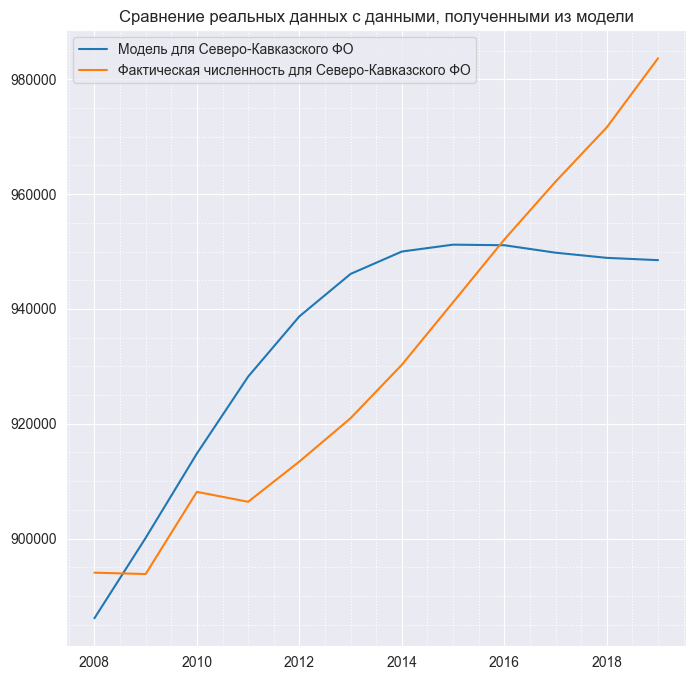

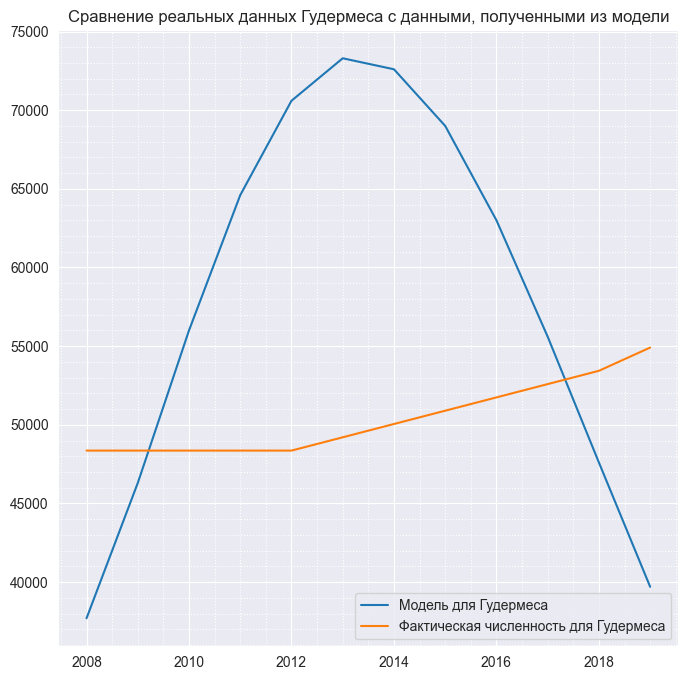

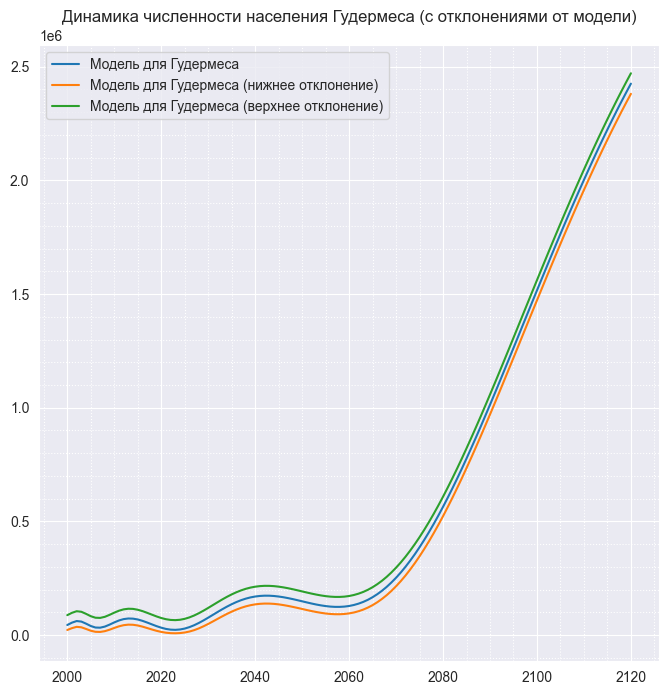

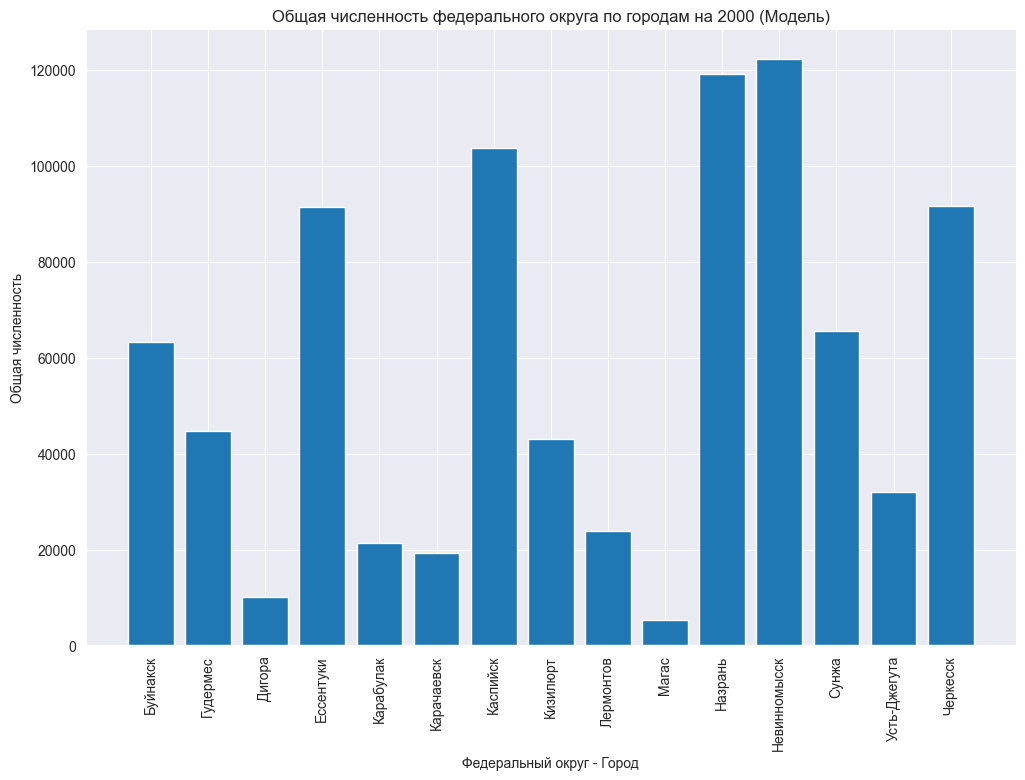

C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\1718423699.py:104: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()


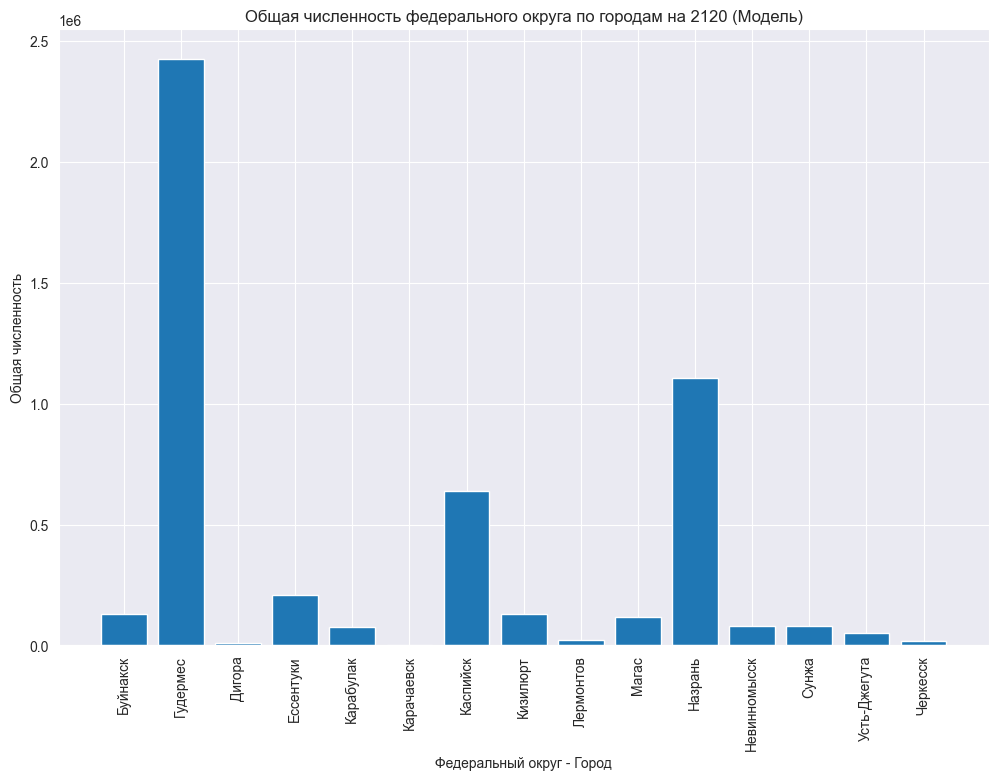

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_6['year'], fdf_6['Модель'], label='Модель для Северо-Кавказского ФО')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Северо-Кавказского ФО')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_6['year'], fdf_6['Модель'], label='Модель для Северо-Кавказского ФО')
ax.plot(fdf_6['year'], fdf_6['Нижняя граница'], label='Модель для Северо-Кавказского ФО (нижнее отклонение)')
ax.plot(fdf_6['year'], fdf_6['Верхняя граница'], label='Модель для Северо-Кавказского ФО (верхнее отклонение)')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Северо-Кавказского ФО (с отклонениями от модели)')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fdf_6_1 = fdf_6.iloc[8:20]
fdf_6_1 = pd.DataFrame(fdf_6_1)
fdf_6_1.head()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_6_1['year'], fdf_6_1['Модель'], label='Модель для Северо-Кавказского ФО')
ax.plot(fdf_6_1['year'], fdf_6_1['fact'], label='Фактическая численность для Северо-Кавказского ФО')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Сравнение реальных данных с данными, полученными из модели')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')
import statsmodels.api as sm

#calculate cross correlation
corr = sm.tsa.stattools.ccf(fdf_6_1['Модель'], fdf_6_1['fact'], adjusted=False)
print("Взаимная корреляция: ", corr)

fdf_6_e = work_df[work_df['Город'] == 'Гудермес']
fdf_6_1_1 = fdf_6_e.iloc[8:20]
fdf_6_1_1 = pd.DataFrame(fdf_6_1_1)
fdf_6_1_1.head()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_6_1_1['year'], fdf_6_1_1['Модель'], label='Модель для Гудермеса')
ax.plot(fdf_6_1_1['year'], fdf_6_1_1['fact'], label='Фактическая численность для Гудермеса')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Сравнение реальных данных Гудермеса с данными, полученными из модели')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')
import statsmodels.api as sm

#calculate cross correlation
corr = sm.tsa.stattools.ccf(fdf_6_1_1['Модель'], fdf_6_1_1['fact'], adjusted=False)
print("Взаимная корреляция данных по Гудермесу: ", corr)
from scipy.stats import spearmanr
correlation, p_value = spearmanr(fdf_6_1_1['Модель'], fdf_6_1_1['fact'])
print("Коэффициент корреляции Спирмена:", correlation)
from scipy.stats import kendalltau
correlation, p_value = kendalltau(fdf_6_1_1['Модель'], fdf_6_1_1['fact'])
print("Коэффициент корреляции Кендалла:", correlation)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_6_e['year'], fdf_6_e['Модель'], label='Модель для Гудермеса')
ax.plot(fdf_6_e['year'], fdf_6_e['Нижняя граница'], label='Модель для Гудермеса (нижнее отклонение)')
ax.plot(fdf_6_e['year'], fdf_6_e['Верхняя граница'], label='Модель для Гудермеса (верхнее отклонение)')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Гудермеса (с отклонениями от модели)')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')



# Выбираем данные для определенного года (например, 2000)
work_df['year'] = pd.to_numeric(work_df['year'], errors='coerce')
work_df['fact'] = work_df['fact'].replace('NA', np.nan)
work_df['fact'] = pd.to_numeric(work_df['fact'], errors='coerce')
work_df['Модель'] = pd.to_numeric(work_df['Модель'], errors='coerce')
work_df['Нижняя граница'] = pd.to_numeric(work_df['Нижняя граница'], errors='coerce')
work_df['Верхняя граница'] = pd.to_numeric(work_df['Верхняя граница'], errors='coerce')
fdf_6_2 = work_df[work_df['federal_district'] == 'Северо-Кавказский']
# fdf_3_2.info()
year_2000_data = fdf_6_2[fdf_6_2['year'] == 2000]
# year_2000_data.head()
grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2000 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()
# Группировка данных по федеральному округу и городу и подсчет общей численности
year_2120_data = fdf_6_2[fdf_6_2['year'] == 2120]
grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2120 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()

Данные основаны на модели прогназирования, поэтому аналогичным образом я оценил их с помощью статистического метода взаимной корреляции. Однако зависимость реальных данных от прогнозных нелинейная, а лишь близка к линейной (если апроксимировать), поэтому классический коэфициент корреляции показывает лишь 0.76939051 . Это аналогично связано с возрастанием численности населения крупного города относительно небольших городов. Поэтому также можно сказать, что модель все равно дает относительно точные предсказания. Максимальное отклонение от прогноза модели составляет 1,9607% (данный процент получается в 2120, там отклонение наибольшее). Отклонения продемонстрированы на втором графике.

Если проанализировать графики численности, то можно заметить, что город Гудермес должен вырасти крайне непропроционально относительно других городов. При этом, по прогнозу, это должно произойти в 2070 года. Проанализировав коэффициенты корреляции, можно одназначно сказать, что такой рост вызван ошибкой модели, т.к. во-первых Гудермес единственный город, который так вырос, а во-вторых это, по прогнозам, произойдет в 2070 году. Такое резкое увелечение численности должно быть вызвано каким-то масштабным событием, и так как данные для других ФО не показывают резкого уменьшения в 2070 году, то можно предположить, что это ошибка модели.

Для экономического анализа необходимо учитывать ошибку модели. С точки зрения инвестирования в инфраструктуру Северо-Кавказского ФО не выгодно, т.к. к 2120 году численность будет медлено увеличиваться. Однако, данное увеличение невогдно даже на долгосрочные вложения, т.к. общая численность все равно не высокая, и не будет активного развития личного дела.

Учитывая медленный рост, можно сделать вывод, что население не планирует мигрировать из Северо-Кавказкого ФО. Однако, если органы местного самоуправления также будут способствовать увелечению числа рабочих мест и улучшению здравоохранения, то в Северо-Кавказский ФО начнется трудовая миграция.

Взаимная корреляция:  [ 0.99437947  0.74508679  0.50227883  0.26659024  0.0496272  -0.13146021
 -0.27612103 -0.38194806 -0.40948878 -0.39196115 -0.34125951 -0.18329806]


C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\2994079239.py:54: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()


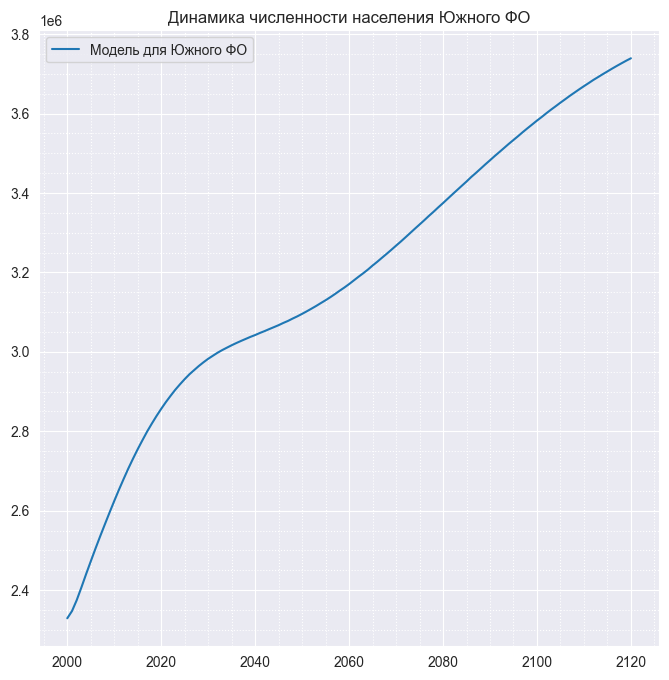

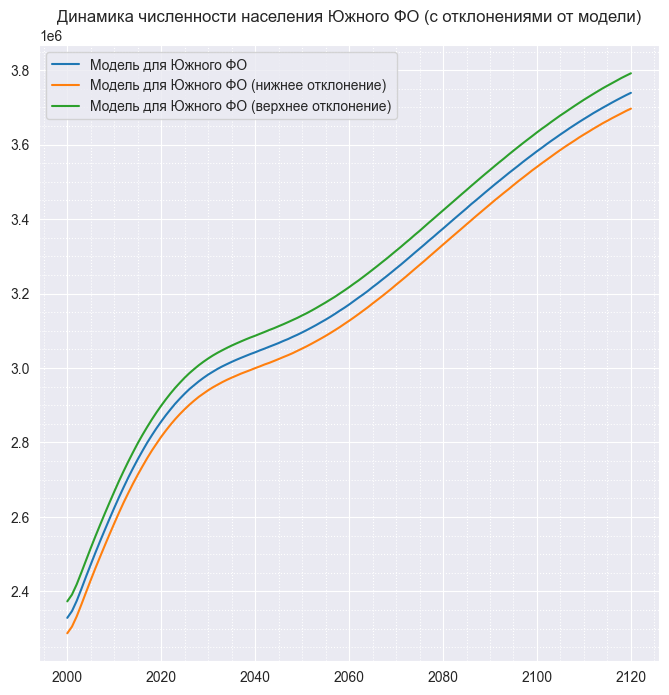

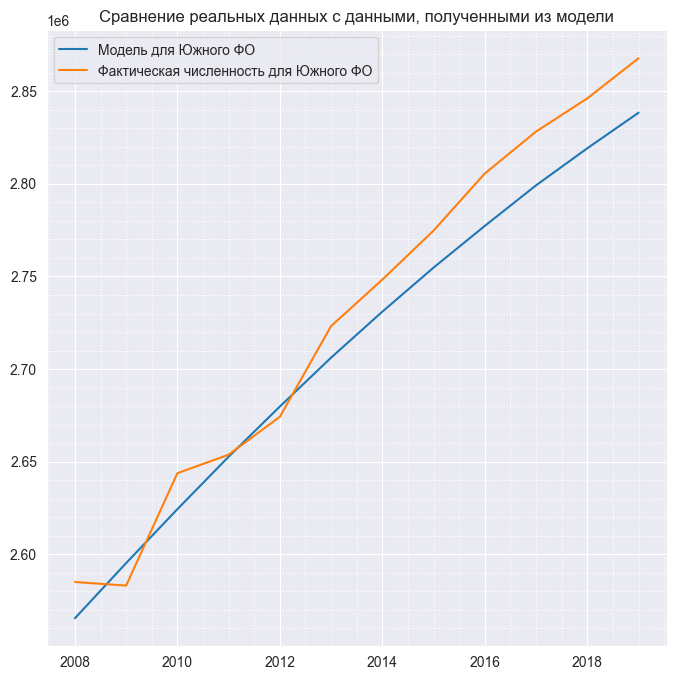

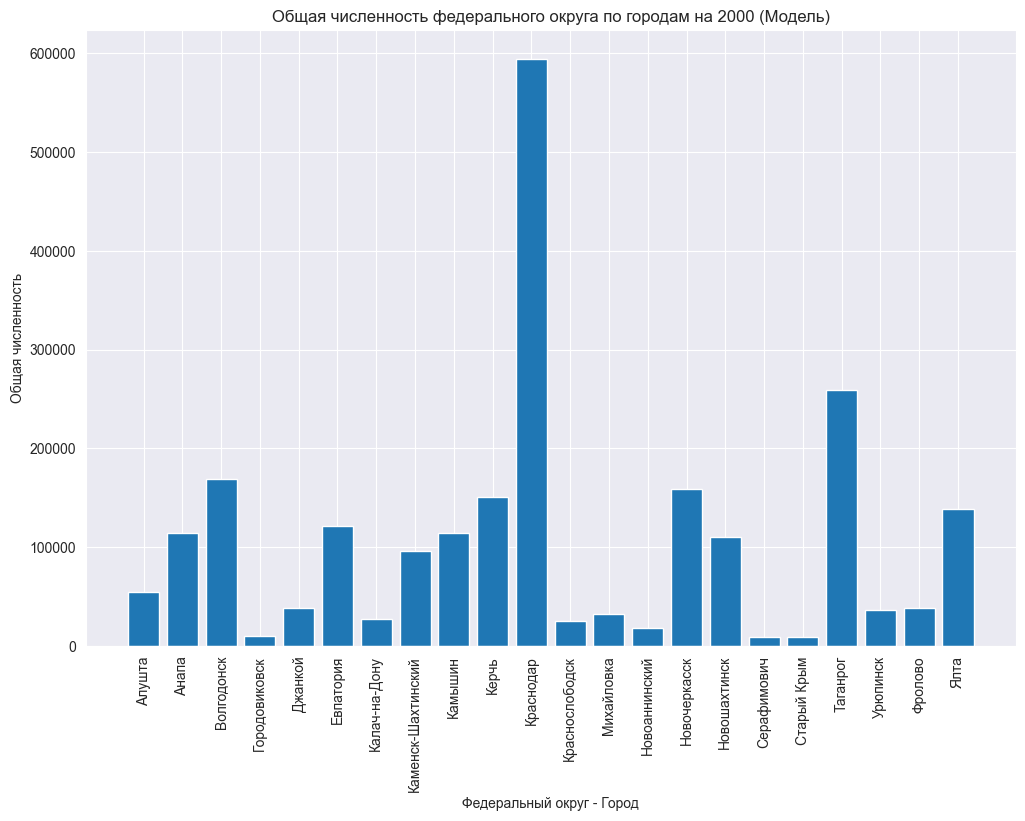

C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\2994079239.py:67: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()


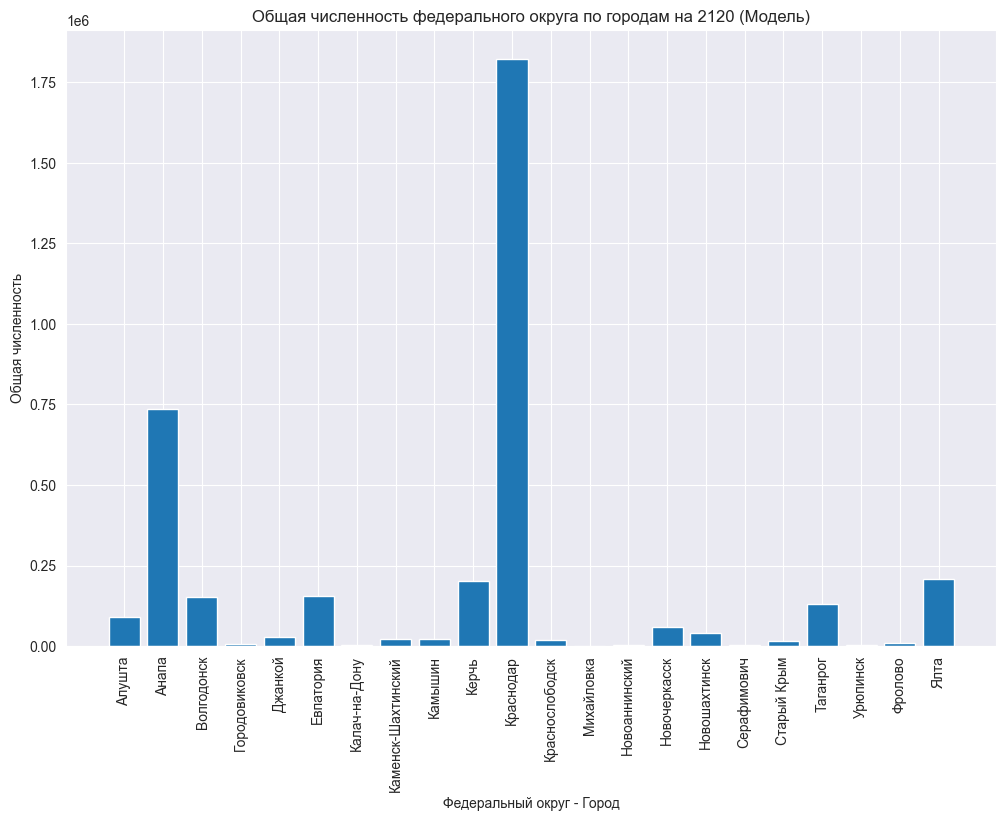

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_7['year'], fdf_7['Модель'], label='Модель для Южного ФО')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Южного ФО')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_7['year'], fdf_7['Модель'], label='Модель для Южного ФО')
ax.plot(fdf_7['year'], fdf_7['Нижняя граница'], label='Модель для Южного ФО (нижнее отклонение)')
ax.plot(fdf_7['year'], fdf_7['Верхняя граница'], label='Модель для Южного ФО (верхнее отклонение)')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Южного ФО (с отклонениями от модели)')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fdf_7_1 = fdf_7.iloc[8:20]
fdf_7_1 = pd.DataFrame(fdf_7_1)
fdf_7_1.head()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_7_1['year'], fdf_7_1['Модель'], label='Модель для Южного ФО')
ax.plot(fdf_7_1['year'], fdf_7_1['fact'], label='Фактическая численность для Южного ФО')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Сравнение реальных данных с данными, полученными из модели')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')
import statsmodels.api as sm

#calculate cross correlation
corr = sm.tsa.stattools.ccf(fdf_7_1['Модель'], fdf_7_1['fact'], adjusted=False)
print("Взаимная корреляция: ", corr)



# Выбираем данные для определенного года (например, 2000)
work_df['year'] = pd.to_numeric(work_df['year'], errors='coerce')
work_df['fact'] = work_df['fact'].replace('NA', np.nan)
work_df['fact'] = pd.to_numeric(work_df['fact'], errors='coerce')
work_df['Модель'] = pd.to_numeric(work_df['Модель'], errors='coerce')
work_df['Нижняя граница'] = pd.to_numeric(work_df['Нижняя граница'], errors='coerce')
work_df['Верхняя граница'] = pd.to_numeric(work_df['Верхняя граница'], errors='coerce')
fdf_7_2 = work_df[work_df['federal_district'] == 'Южный']
# fdf_3_2.info()
year_2000_data = fdf_7_2[fdf_7_2['year'] == 2000]
# year_2000_data.head()
grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2000 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()
# Группировка данных по федеральному округу и городу и подсчет общей численности
year_2120_data = fdf_7_2[fdf_7_2['year'] == 2120]
grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2120 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()

Данные основаны на модели прогназирования. Поэтому, я также оценил их с помощью взаимной корреляционной функции. Это возможно, т.к. зависимость линейная (третий график).Коэффициент кореляции равен 0.99437947 , следовательно модель сделала статистический прогноз достаточно точно. Наибольшее отклонение наблюдается в 2120 году и составляет 
1,351%. Отклонение продемонстрировано на втором графике.

Общая динамика численности Южного ФО положительная. Она имеет сходства с динамикой Центрального ФО. Зависимость похожа на логарифмическую. Рассмотрим задачу инвестирования. Вкладываться в Южный федеральный округ в развитие городской инфраструктуры выгодно на любой срок, т.к. население вырастет примерно в 1,5 раза (наибольшее возможное отклонение составляет 1,351), как и, соответственно, спрос на жилые помещения. Помимо этого, Южный ФО пользуется спросом у туристов (данные не включают это, просто логическтй домысел), так что возможно повышенное получение доходов при инвестировании в инфраструктуру. Однако, т.к рост логарифмический и замедляется со временем, наиболее выгодно рассматривать краткосрочную перспективу и начинать действовать прямо сейчас.

Из переспективных городов можно выделить: Краснодар, Анапу и Ялту.

Рост численности населения также может говорить о высоком качестве здравоохранения.

Взаимная корреляция:  [ 0.914807    0.6982273   0.45844204  0.19883583 -0.05286919 -0.26086528
 -0.39092239 -0.43248187 -0.39722137 -0.28519908 -0.18605621 -0.09621063]


C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\1550602315.py:54: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()


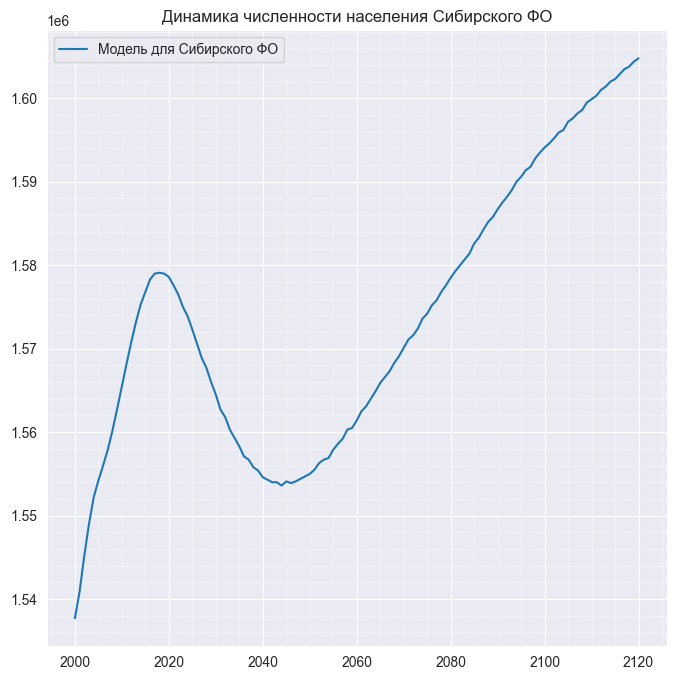

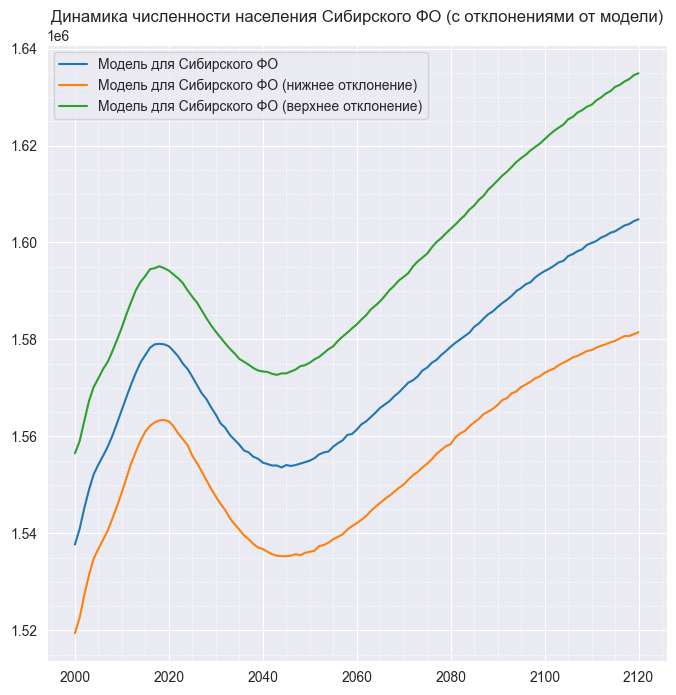

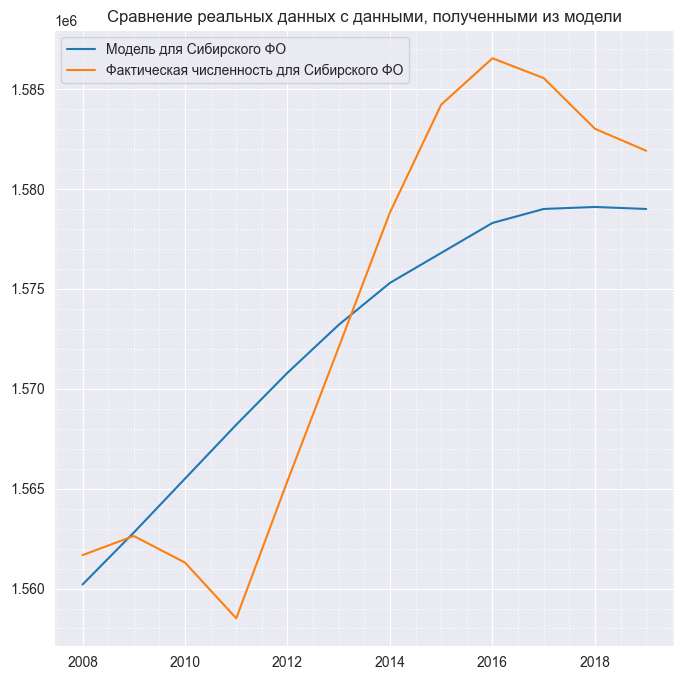

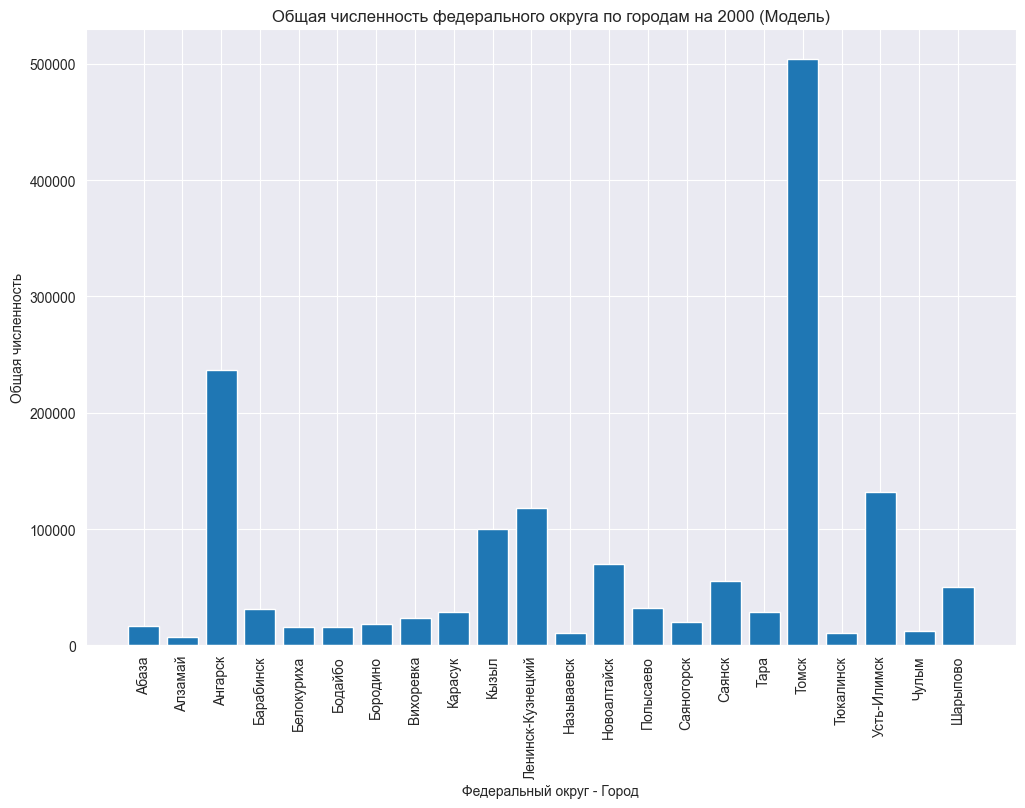

C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\1550602315.py:67: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()


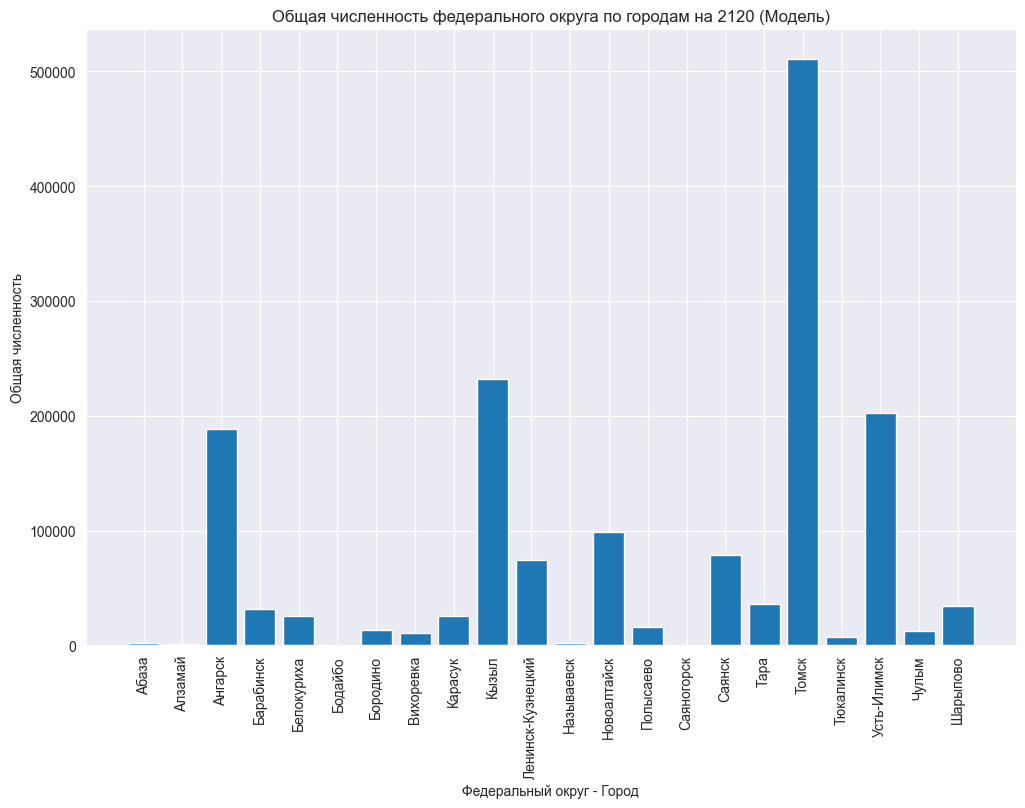

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_8['year'], fdf_8['Модель'], label='Модель для Сибирского ФО')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Сибирского ФО')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_8['year'], fdf_8['Модель'], label='Модель для Сибирского ФО')
ax.plot(fdf_8['year'], fdf_8['Нижняя граница'], label='Модель для Сибирского ФО (нижнее отклонение)')
ax.plot(fdf_8['year'], fdf_8['Верхняя граница'], label='Модель для Сибирского ФО (верхнее отклонение)')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Сибирского ФО (с отклонениями от модели)')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fdf_8_1 = fdf_8.iloc[8:20]
fdf_8_1 = pd.DataFrame(fdf_8_1)
fdf_8_1.head()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_8_1['year'], fdf_8_1['Модель'], label='Модель для Сибирского ФО')
ax.plot(fdf_8_1['year'], fdf_8_1['fact'], label='Фактическая численность для Сибирского ФО')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Сравнение реальных данных с данными, полученными из модели')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')
import statsmodels.api as sm

#calculate cross correlation
corr = sm.tsa.stattools.ccf(fdf_8_1['Модель'], fdf_8_1['fact'], adjusted=False)
print("Взаимная корреляция: ", corr)



# Выбираем данные для определенного года (например, 2000)
work_df['year'] = pd.to_numeric(work_df['year'], errors='coerce')
work_df['fact'] = work_df['fact'].replace('NA', np.nan)
work_df['fact'] = pd.to_numeric(work_df['fact'], errors='coerce')
work_df['Модель'] = pd.to_numeric(work_df['Модель'], errors='coerce')
work_df['Нижняя граница'] = pd.to_numeric(work_df['Нижняя граница'], errors='coerce')
work_df['Верхняя граница'] = pd.to_numeric(work_df['Верхняя граница'], errors='coerce')
fdf_8_2 = work_df[work_df['federal_district'] == 'Сибирский']
# fdf_3_2.info()
year_2000_data = fdf_8_2[fdf_8_2['year'] == 2000]
# year_2000_data.head()
grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2000 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()
# Группировка данных по федеральному округу и городу и подсчет общей численности
year_2120_data = fdf_8_2[fdf_8_2['year'] == 2120]
grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2120 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()

Данные основаны на модели прогназирования. Поэтому, я также оценил их с помощью взаимной корреляционной функции. Это возможно, т.к. зависимость близка к линейной (третий график).Коэффициент кореляции равен 0.914807, следовательно модель сделала статистический прогноз достаточно точно. Наибольшее отклонение наблюдается в 2120 году и составляет 
1,86916%. Отклонение продемонстрировано на втором графике.

Общая динамика численности Сибирского ФО неодназначная. Значение числености растет к 2020, пораболически падает к 2040 году, а затем логарифмически растет к 2120. Это отражено на первом графике. Выделим также задачу инвестирования, чтобы сделать экономические выводы. Сравнивавая четвертый и пятый графики, можно сделать вывод, что далеко не все города Сибирского ФО логарифмически увеличили свою численность. Произошло перераспределение населения, поэтому численность одной части городов немного возрасла (согласно прогнозу), а в другой части немного упала. Города, которые действительно выросли: Усть-Ильминск и Кызыл. Учитывая, что сначала прогназируется упадок, инвестирование в инфраструктуру - невыгодно. Но т.к. модель может не учитывать события, которые в дальнейшем могут сильно ударить по численности население, лучше вообще не инвестировать в Сибирский ФО (если мы принимаем решение по данным модели). 

Перераспределение населения говорит о том, что в данном федеральном округе возможна трудовая миграция. Люди перезжают в другие города округа с целью поиска новых рабочих мест. Местному самоуправлению (возможно) стоит обратить внимание и повлиять на количество рабочих и условия работы. Таким образом, возможно так же будет предотвращен прогнозный упадок к 2040 году.

Так же, стоит отметить, что у города Томск, который крупнее представленных городов в данном округе, почти не изменилась численность насления за 120 прогнозных лет. В Сибири тяжелые климатические условия (многие люди покидают город), и учитывая что численность почти не изменилась, скорее всего там есть естейственный прирост населения и механическая убыль. Учитывая, что в Томске находятся несколько крупных нефте-газодобывающих предприятий, стоит задуматься об улучшении условий труда и повышения качества жизни, чтобы не происходила миграция.

Взаимная корреляция:  [ 0.38391504  0.51977821  0.56839885  0.55103587  0.46600869  0.30727437
  0.0611721  -0.21977193 -0.36268398 -0.33870682 -0.14671527 -0.05465576]


C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\4254312225.py:54: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()


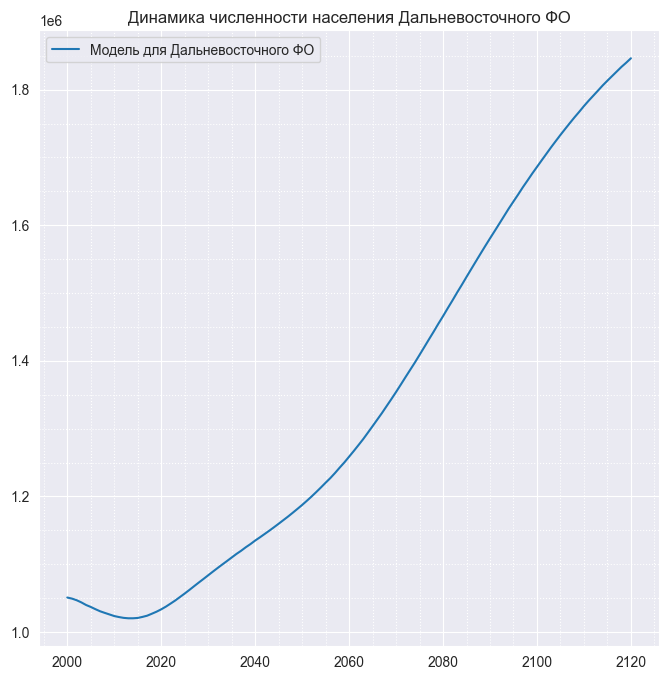

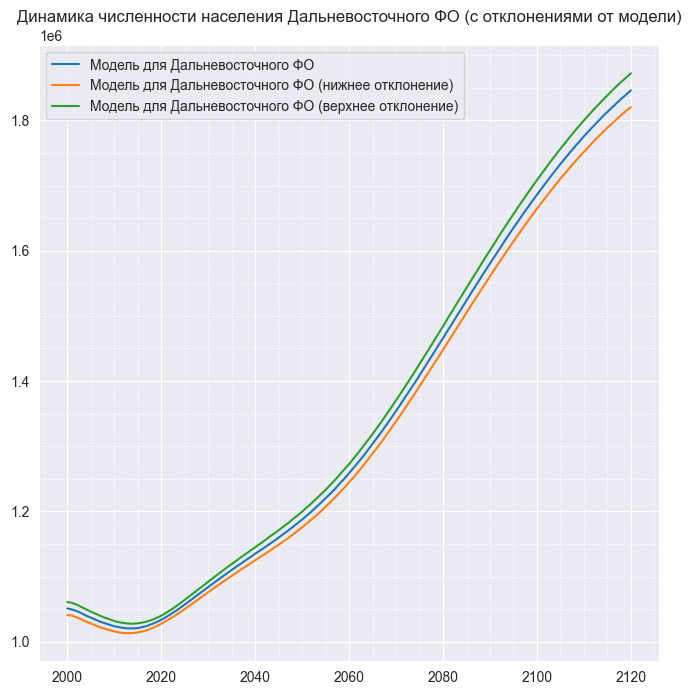

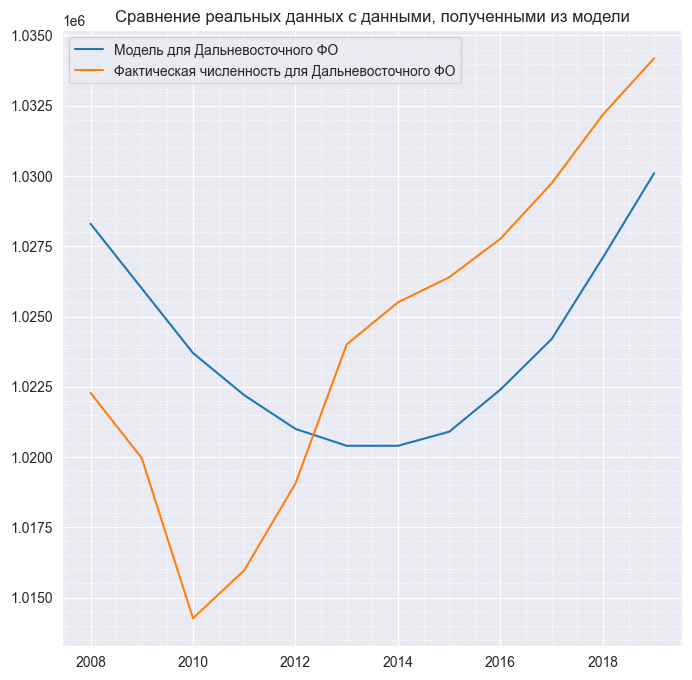

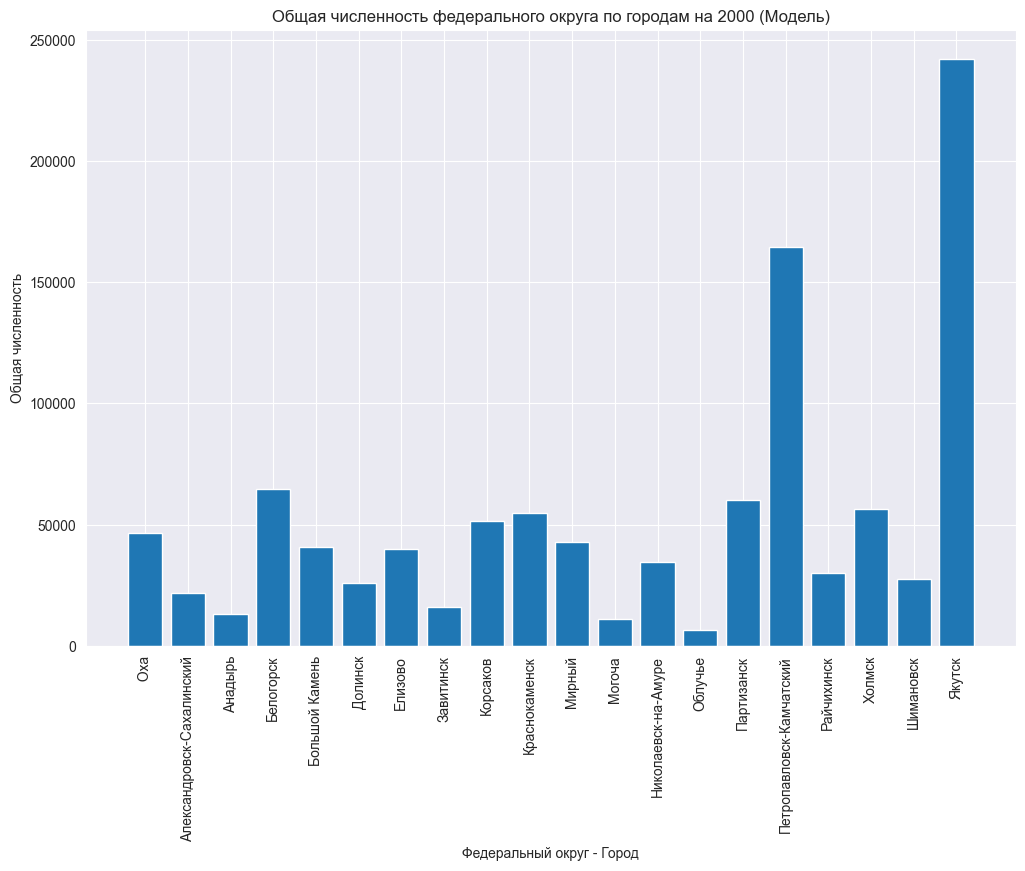

C:\Users\Егор\AppData\Local\Temp\ipykernel_24012\4254312225.py:67: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()


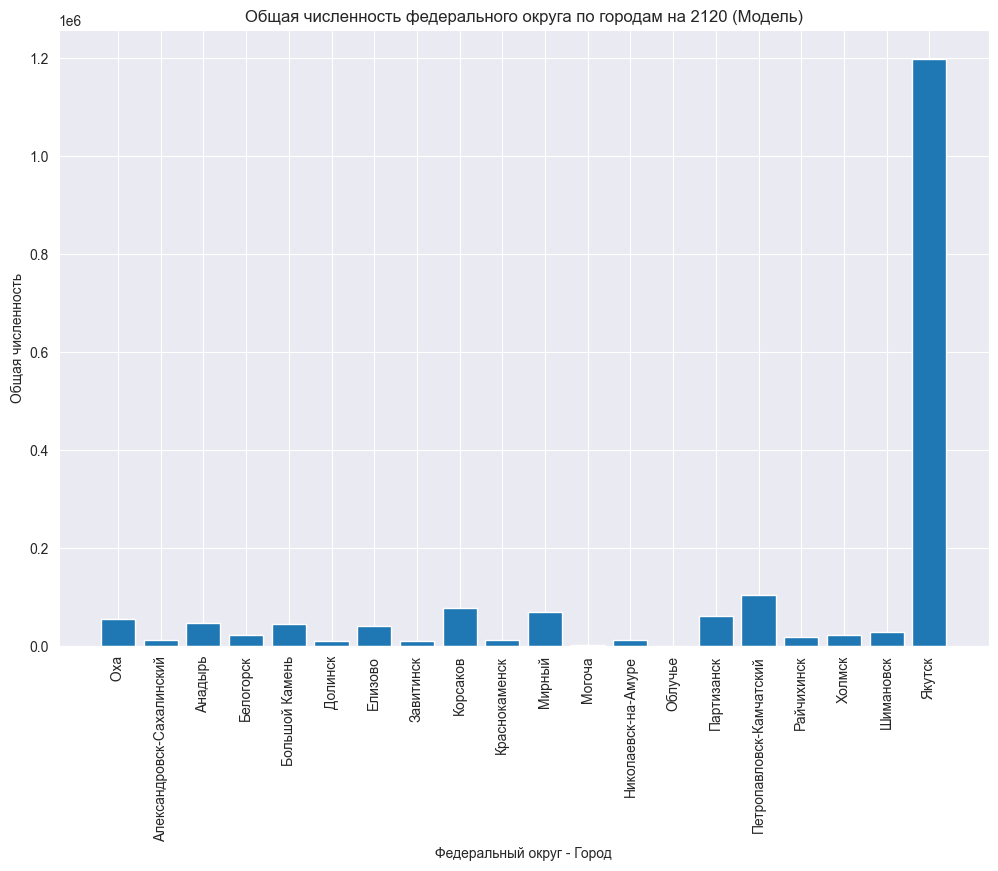

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_1['year'], fdf_1['Модель'], label='Модель для Дальневосточного ФО')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Дальневосточного ФО')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_1['year'], fdf_1['Модель'], label='Модель для Дальневосточного ФО')
ax.plot(fdf_1['year'], fdf_1['Нижняя граница'], label='Модель для Дальневосточного ФО (нижнее отклонение)')
ax.plot(fdf_1['year'], fdf_1['Верхняя граница'], label='Модель для Дальневосточного ФО (верхнее отклонение)')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Динамика численности населения Дальневосточного ФО (с отклонениями от модели)')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

fdf_1_1 = fdf_1.iloc[8:20]
fdf_1_1 = pd.DataFrame(fdf_1_1)
fdf_1_1.head()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fdf_1_1['year'], fdf_1_1['Модель'], label='Модель для Дальневосточного ФО')
ax.plot(fdf_1_1['year'], fdf_1_1['fact'], label='Фактическая численность для Дальневосточного ФО')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.title('Сравнение реальных данных с данными, полученными из модели')
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')
import statsmodels.api as sm

#calculate cross correlation
corr = sm.tsa.stattools.ccf(fdf_1_1['Модель'], fdf_1_1['fact'], adjusted=False)
print("Взаимная корреляция: ", corr)



# Выбираем данные для определенного года (например, 2000)
work_df['year'] = pd.to_numeric(work_df['year'], errors='coerce')
work_df['fact'] = work_df['fact'].replace('NA', np.nan)
work_df['fact'] = pd.to_numeric(work_df['fact'], errors='coerce')
work_df['Модель'] = pd.to_numeric(work_df['Модель'], errors='coerce')
work_df['Нижняя граница'] = pd.to_numeric(work_df['Нижняя граница'], errors='coerce')
work_df['Верхняя граница'] = pd.to_numeric(work_df['Верхняя граница'], errors='coerce')
fdf_1_2 = work_df[work_df['federal_district'] == 'Дальневосточный']
# fdf_3_2.info()
year_2000_data = fdf_1_2[fdf_1_2['year'] == 2000]
# year_2000_data.head()
grouped_df = year_2000_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2000 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()
# Группировка данных по федеральному округу и городу и подсчет общей численности
year_2120_data = fdf_1_2[fdf_1_2['year'] == 2120]
grouped_df = year_2120_data.groupby(['federal_district', 'Город']).sum().reset_index()

# Создание диаграммы
fig, ax = plt.subplots(figsize=(12, 8))
x = grouped_df['Город']  # Составляем подписи для баров
ax.bar(x, grouped_df['Модель'])
plt.title('Общая численность федерального округа по городам на 2120 (Модель)')
plt.xlabel('Федеральный округ - Город')
plt.ylabel('Общая численность')
plt.xticks(rotation=90)  # Поворачиваем подписи оси X для удобства чтения
plt.show()

Данные основаны на модели прогназирования. Поэтому, я также хотел оценить их с помощью взаимной корреляционной функции. Однако данная зависимость - нелинейная. Основываясь на личном опыте анализа данного датафрема, я могу сделать, что данные модели просто апроксимировались, и не соответсвие прогнозной и реальной численности происходит из-за разной численности между городами, составлящими данный федеральный округ. А это значит, что при небольшом росте крупного города, общая численность сильно вырастает, что отражается на моедли. Поэтому можно использовать прогнозные данные.

Общая динамика численности Даьневосточного ФО положительна. Значение числености растет к 2120. Это отражено на первом графике. Функция напоминает пораболическую. Выделим также задачу инвестирования, чтобы сделать экономические выводы. Сравнивавая четвертый и пятый графики, можно заметить что только население Якутска сильно возрастает. Он является административным центром. Скорее всего, помимо естейственого прироста населения, люди мигрируют в него. Поэтому есть смысл инвестировать кокретно в инфраструтуру Якуска.

К сожалению, из-за тяжелых климатических условий в Дальневосточном ФО невозможно выяснить точно, по какой причине в других городах прогназируется убыль населения. В данном ФО существует проблема высоких цен на продукты потребления и ЖКХ, но местное самоуправление ничего не может с этим поделать.

Анаализ ФО между собой

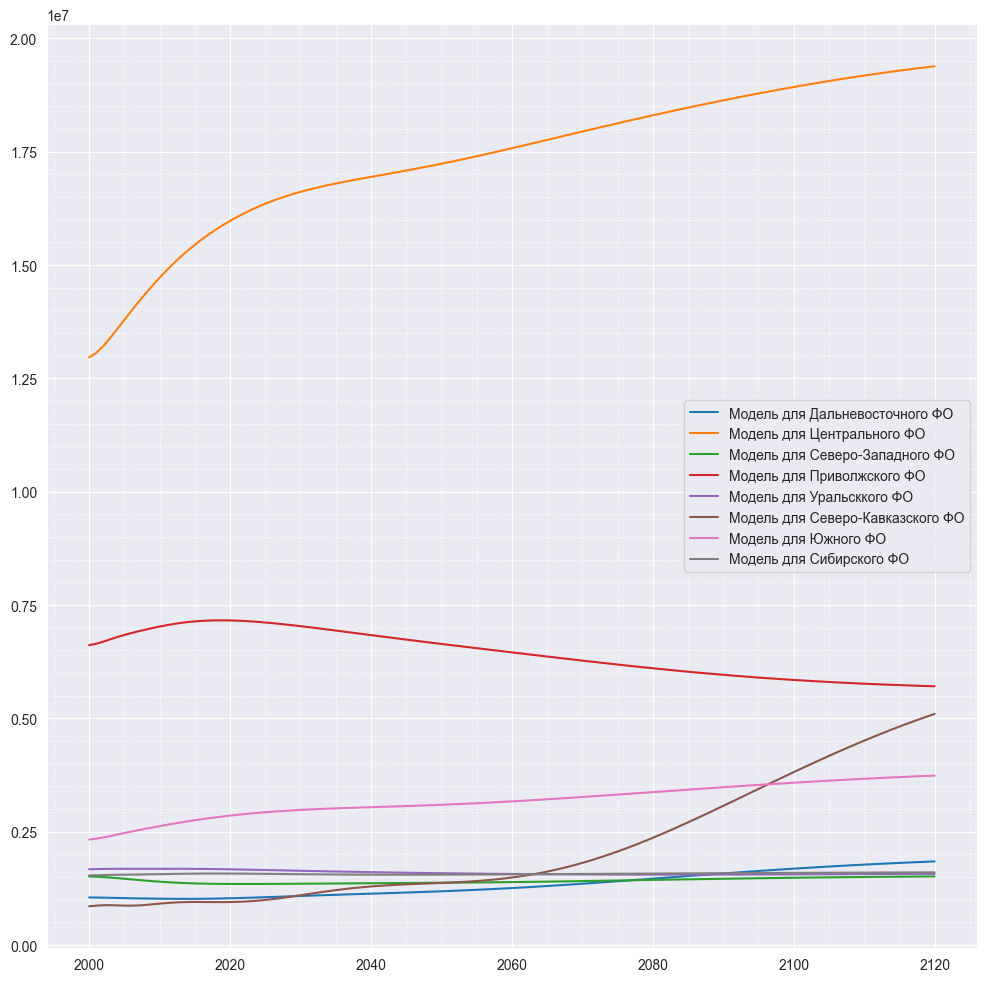

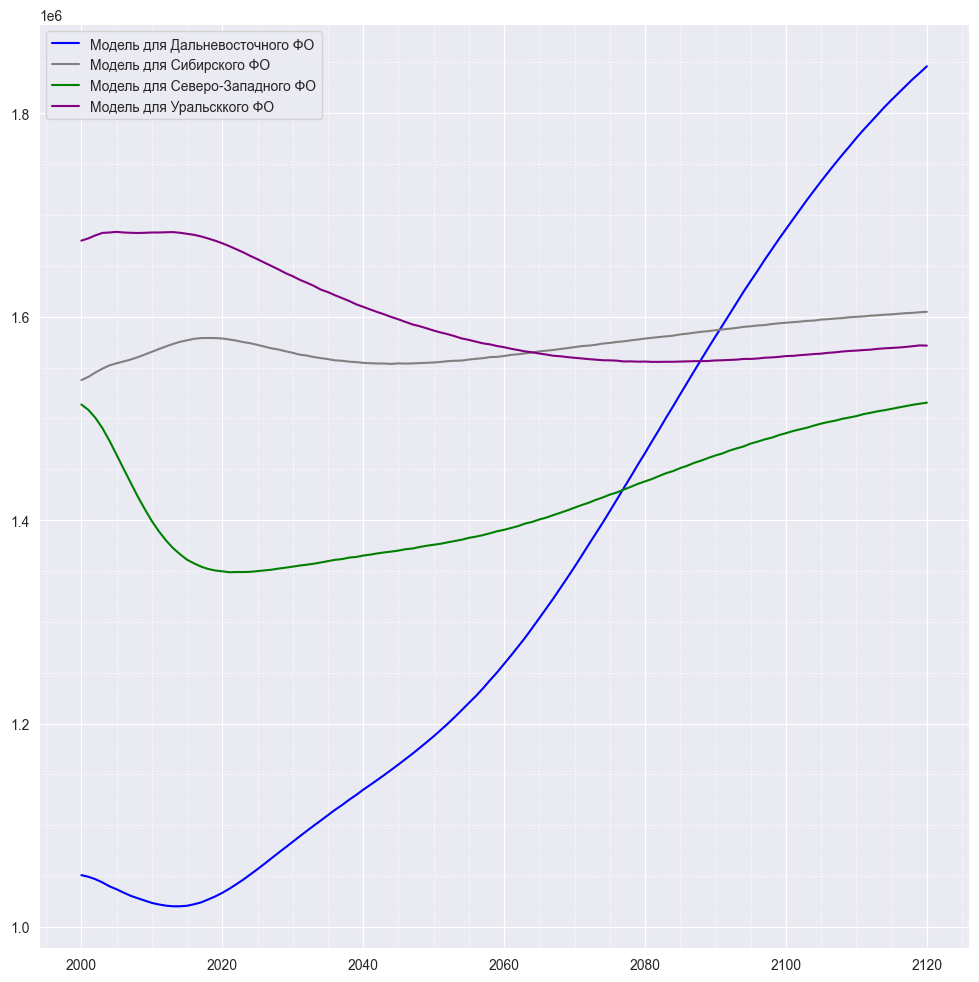

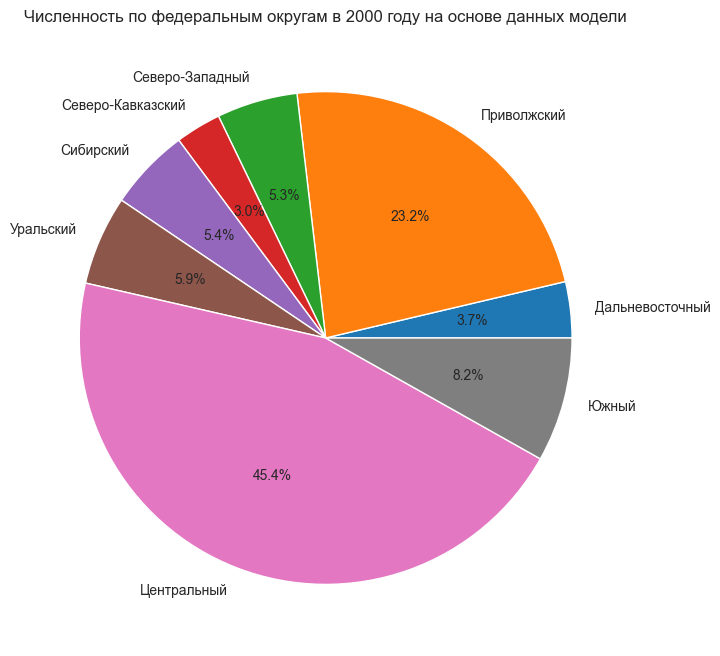

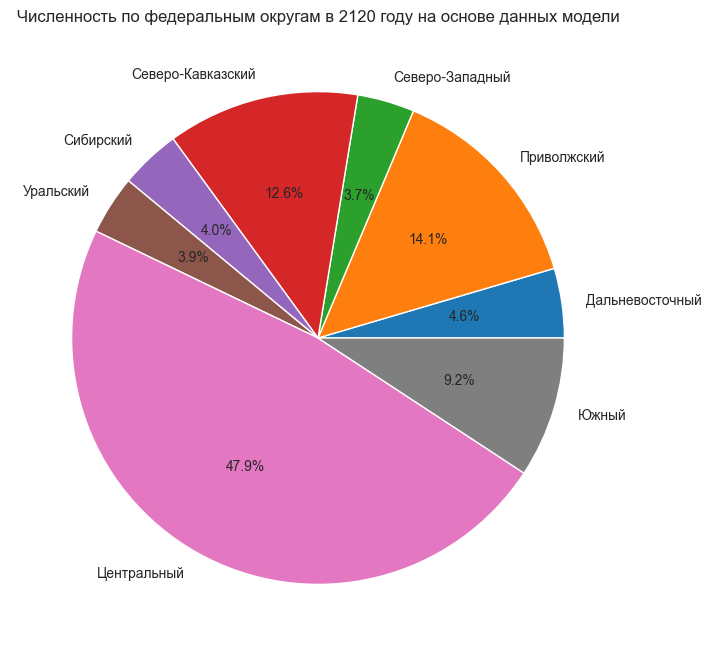

In [40]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(fdf_1['year'], fdf_1['Модель'], label='Модель для Дальневосточного ФО')
ax.plot(fdf_2['year'], fdf_2['Модель'], label='Модель для Центрального ФО')
ax.plot(fdf_3['year'], fdf_3['Модель'], label='Модель для Северо-Западного ФО')
ax.plot(fdf_4['year'], fdf_4['Модель'], label='Модель для Приволжского ФО')
ax.plot(fdf_5['year'], fdf_5['Модель'], label='Модель для Уральсккого ФО')
ax.plot(fdf_6['year'], fdf_6['Модель'], label='Модель для Северо-Кавказского ФО')
ax.plot(fdf_7['year'], fdf_7['Модель'], label='Модель для Южного ФО')
ax.plot(fdf_8['year'], fdf_8['Модель'], label='Модель для Сибирского ФО')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')

'''Графики для Дальневосточного, Сибирского, Северо-Западного и Уральского федеральный округов сливаются при данном масштабе. Сделаем отдельный график.'''
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(fdf_1['year'], fdf_1['Модель'], label='Модель для Дальневосточного ФО', color = 'blue')
ax.plot(fdf_8['year'], fdf_8['Модель'], label='Модель для Сибирского ФО', color = 'grey')
ax.plot(fdf_3['year'], fdf_3['Модель'], label='Модель для Северо-Западного ФО', color ='green')
ax.plot(fdf_5['year'], fdf_5['Модель'], label='Модель для Уральсккого ФО', color = 'purple')
ax.set_xticks([2000, 2020, 2040, 2060, 2080, 2100, 2120])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.grid(True, which='major')
plt.minorticks_on() # Включаем минорные деления
plt.grid(True, which='minor', linestyle=':', linewidth='0.8')
year_2000_data = final_work_df[final_work_df['year'] == 2000]
# Строим круговую диаграмму численности федерального округа
plt.figure(figsize=(8, 8))
plt.pie(year_2000_data['Модель'], labels=year_2000_data['federal_district'], autopct='%1.1f%%')
plt.title('Численность по федеральным округам в 2000 году на основе данных модели')
plt.show()

year_2120_data = final_work_df[final_work_df['year'] == 2120]
# Строим круговую диаграмму численности федерального округа
plt.figure(figsize=(8, 8))
plt.pie(year_2120_data['Модель'], labels=year_2120_data['federal_district'], autopct='%1.1f%%')
plt.title('Численность по федеральным округам в 2120 году на основе данных модели')
plt.show()



На первом графике динамика населения каждого федерального округа. На втором графике увеличенный мастаб для Дальневосточного, Сибирского, Северо-Западного и Уральского ФО, т.к. на первом графике тяжело увидеть зависимость. Если подводить итог и делать общий вывод, опираясь на анализ каждого округа, если приследуется цель инвестирования, то лучше всего инвестировать в инфраструктуру Центрального ФО т.к. там прогнозируется самый высокий количественный прирост населения. Если же цель - повышение качества жизни и замедление убыли населения, то стоит обратить внимание на Уральский ФО и Приволжский ФО. Графики три и четыре отражают процентное изменение общей численности населения по федеральным округам за 120 лет. Стоит отметить, что в пункте про Северо-Кавказский ФО я сделал заявление, что модель сделал ошибочный прогноз для города Гудермес. Я не стал выбрасывать его данные при построение общей диаграммы, т.к. у него все же есть численность, которая скорее всего будет плавно увеличивать. И т.к. я не имею доступа к модели, чтобы получить новые исправленные данные, я использовал его прогнозные данные при построении диаграммы.